<a href="https://colab.research.google.com/github/JhCandiceYao/Programming_Skill_Demo/blob/main/Python/Twitter_Dataset_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Dataset - Computational Project


This is (the truncated version of) a Google Colab Notebook I've been working on for my computational Project with Professor Bart Bonikowski that explores the climate change discussion on Twitter and U.S. political polarization. Please note that this notebook is for demonstration purpose and it is not supposed to be ran since the data sources are blurred out since this is still an ongoing project.



Handling this large dataset, I first defined functions and criteria to generat user objects. Since the data was collected before Twitter shut down its free academic API access(June 23rd, 2023), user metadata such as geo-location, following network, etc. that are crucial for our analyses are lacking. Many codes in this notebook are devoted to using inferential methods to address this issue and aim for a clean and rigorous dataset. For instance, the 'layers' are algorithms to identify active, English-Speaking, U.S.-residing users.



There are also codes involving the uses of text data processing(Regular Expression, tokenization, etc), interaction with the Twitter API, NLP techniques(fine-tuning Bert model), and LLM Prompting(LLama2 for tweet classification). In addition, I also conducted a series of data visualization and descritive explorations here in order to better understand the data.

In [1]:
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install evaluate
!pip install operation
!pip install schema

In [ ]:
from google.colab import drive
import os
import pandas as pd
import csv
from datasets import Dataset
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import json
import numpy as np
import pytz
from itertools import chain
import nltk
import random
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments
import evaluate
import re
import gc

In [ ]:
# #transformers dependencies
from transformers import Trainer,AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_metric
import torch

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.chdir('/content/drive/MyDrive/api_data/')

In [ ]:
ls

'BB - random_timelines - 10.csv'   random_timelines09.csv
'BB - random_timelines - 11.csv'   random_timelines10.csv
'BB - random_timelines - 12.csv'   random_timelines11.csv
'BB - random_timelines - 13.csv'   random_timelines12.csv
'BB - random_timelines - 14.csv'   random_timelines13.csv
'BB - random_timelines - 15.csv'   random_timelines14.csv
'BB - random_timelines - 16.csv'   random_timelines_april2023_1.csv
'BB - random_timelines - 17.csv'   random_timelines_april2023_2.csv
'BB - random_timelines - 18.csv'   random_timelines_april2023_3.csv
'BB - random_timelines - 19.csv'   random_timelines_april2023_4.csv
'BB - random_timelines - 1.csv'    random_timelines_feb2023_01.csv
'BB - random_timelines - 20.csv'   random_timelines_feb2023_02.csv
'BB - random_timelines - 21.csv'   random_timelines_feb2023_03.csv
'BB - random_timelines - 22.csv'   random_timelines_feb2023_04.csv
'BB - random_timelines - 23.csv'   random_timelines_feb2023_05.csv
'BB - random_timelines - 24.csv'   random_tim

In [ ]:
cd /content/drive/MyDrive/api_data/for_data_processing/

/content/drive/.shortcut-targets-by-id/1fXHrAwlPV8OcV4hILOO-sKi-2N1cCxZ7/api_data/for_data_processing


In [ ]:
# get the current working directory
cwd = os.getcwd()

# grant file executable permission
for filename in os.listdir(cwd):
    if os.path.isfile(os.path.join(cwd, filename)):
        os.chmod(os.path.join(cwd, filename), 0o755)

# Metadata Collection from Twitter API



In [ ]:
### Auth

def bearer_oauth_user(r):
    """
    Method for bearer token authentication
    """
    My_bearer = # my twitter api bearer token
    r.headers["Authorization"] = f"Bearer {My_bearer}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r

In [ ]:
### read existing user ids

df1 = pd.read_csv('unique_users_1.csv') #FINISHED!!
df2 = pd.read_csv('unique_users_2.csv')
df3 = pd.read_csv('unique_users_3.csv')
df4 = pd.read_csv('unique_users_4.csv')

user_id_list_1 = df1["author_id"].tolist()
user_id_list_2 = df2["author_id"].tolist()
user_id_list_3 = df3["author_id"].tolist()
user_id_list_4 = df4["author_id"].tolist()

In [ ]:
params = {
    'user.fields': 'created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,url,username,verified,verified_type,withheld'
}


def get_user_metadata(user_id):
    url = f"https://api.twitter.com/2/users/{user_id}"
    response = requests.get(url, auth=bearer_oauth_user, params=params)
    check_rate_limit(response)
    data = json.loads(response.text)
    return data

def check_rate_limit(response):
    remaining = int(response.headers.get('x-rate-limit-remaining', 0))
    reset_time = int(response.headers.get('x-rate-limit-reset', 0))
    current_time = time.time()
    if remaining == 0:
        sleep_time = reset_time - current_time
        print(f"Rate limit exceeded. Sleeping for {sleep_time} seconds...")
        time.sleep(sleep_time)

    return remaining

In [ ]:
# last_id = 14548964 # manually log the last_id collected if execution halted

# since there are currently four files, we need to run four times to generate four output files

csv_file = 'user_metadata01.csv'  # MODIFY the filename when you run a new loop
fieldnames = ['user_id', 'created_at', 'description', 'entities', 'id', 'location', 'name', 'pinned_tweet_id', 'profile_image_url', 'protected', 'public_metrics', 'url', 'username', 'verified', 'verified_type', 'withheld']

if last_id:
    last_loc = user_id_list_1.index(last_id)
else:
    last_loc = 0 ### default start from location 0

while (last_loc+1) < len(user_id_list_1):
    with open(csv_file, 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        if last_loc == 0:
            writer.writeheader() # write header when the starting location is at zero

        for user_id in tqdm(user_id_list_1[last_loc:], total=len(user_id_list_1[last_loc:])):
            while True:
                last_loc = user_id_list_1.index(user_id)
                try:
                    user_metadata = get_user_metadata(user_id)
                    if 'errors' in user_metadata:
                        print(f"The user with the id {user_id} does not exist.")
                    else:

                        data = user_metadata['data']
                        row = {
                            'user_id': user_id,
                            'created_at': data.get('created_at', ''),
                            'description': data.get('description', ''),
                            'entities': data.get('entities', ''),
                            'id': data.get('id', ''),
                            'location': data.get('location', ''),
                            'name': data.get('name', ''),
                            'pinned_tweet_id': data.get('pinned_tweet_id', ''),
                            'profile_image_url': data.get('profile_image_url', ''),
                            'protected': data.get('protected', ''),
                            'public_metrics': data.get('public_metrics', ''),
                            'url': data.get('url', ''),
                            'username': data.get('username', ''),
                            'verified': data.get('verified', ''),
                            'verified_type': data.get('verified_type', ''),
                            'withheld': data.get('withheld', '')
                        }
                        writer.writerow(row)

                except Exception as e:
                    print(f"An error occurred: {e}. Saving last user id ({last_loc}) and restarting the loop...")
                    continue
                break

# Generate User Objects

In [ ]:
class User:
    def __init__(self, author_id):
        self.author_id = author_id
        self.unique_tweets = set()  # Set for composite keys to check uniqueness
        self.tweet_ids = set()      # Set to store individual tweet IDs
        self.all_lang = []          # List to hold languages of tweets
        self.all_time = []          # List to hold timestamps of tweets
        self.all_tweet = []         # List to hold tweet texts
        self.eng_percentage = 0.0   # Percentage of English tweets

    def add_tweet(self, composite_key, tweet_id, lang, time, tweet):
        if composite_key not in self.unique_tweets:
            self.unique_tweets.add(composite_key)
            self.tweet_ids.add(tweet_id)  # Store the tweet ID
            self.all_lang.append(lang)
            self.all_time.append(time)
            self.all_tweet.append(tweet)

    def calculate_eng_percentage(self):
        if not self.all_lang:
            return  # Avoid division by zero
        eng_count = sum(1 for lang in self.all_lang if lang == 'en')
        self.eng_percentage = (eng_count / len(self.all_lang)) * 100


In [ ]:
directory = os.getcwd()
last_author_ids = []
for file_name in tqdm(os.listdir(directory), desc="Processing CSV files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join(directory, file_name)
        with open(file_path, 'r', encoding='utf-8') as csv_file:
            lines = csv_file.readlines()
            last_line = lines[-1]
            last_id = last_line.split(',')[1]
            last_author_ids.append(last_id)


Processing CSV files: 100%|██████████| 83/83 [03:44<00:00,  2.71s/it]


In [ ]:
#save users to pickle
with open("unfiltered_all_users.pkl", "wb") as file:
    pickle.dump(users, file, protocol=4)

In [ ]:
cd for_data_processing/

/content/drive/.shortcut-targets-by-id/1fXHrAwlPV8OcV4hILOO-sKi-2N1cCxZ7/api_data/for_data_processing


In [ ]:
with open("unfiltered_all_users.pkl", "rb") as file:
    users = pickle.load(file)

# Layer 1 - Excluding non-English-Speaking Users

## 1) By Checking User Timeline Language Percentage

In [ ]:
class User:
    def __init__(self, author_id):
        self.author_id = author_id
        self.all_lang = []
        self.all_time = []
        self.all_tweet = []
        self.eng_percentage = 0.0
        self.eng_word_percentage = 0.0
        self.is_eng = False

    def add_lang(self, lang):
        self.all_lang.append(lang)

    def add_time(self,time):
        self.all_time.append(time)

    def add_tweet(self,tweet):
        self.all_tweet.append(tweet)


    def calculate_eng_percentage(self):
        if not self.all_lang:
            return
        eng_count = sum(1 for lang in self.all_lang if lang == 'en')
        self.eng_percentage = (eng_count / len(self.all_lang)) * 100
        self.half_eng = self.eng_percentage > 50

    def calculate_eng_word_percentage(self):
      file_path = '/content/drive/My Drive/moby_project_english_words/moby_project_english_words_alpha.txt'
      with open(file_path, 'r') as file:
        eng_word_list = [i.strip() for i in file]
        if not self.all_lang:
              return
        all_words = [tweet.split() for tweet in self.all_tweet]
        flatten_words = list(chain.from_iterable(all_words))

        #calculate user's percentage of words used from the list

        total_words = len(flatten_words)
        english_words = sum(1 for word in flatten_words if word.lower() in eng_word_list)
        self.eng_word_percentage = english_percentage = (english_words / total_words) * 100 if total_words > 0 else 0


          ##tbd: remove'@', handle punctuation better



In [ ]:
# load all original user object(uncleaned)
with open("all_users.pkl", "rb") as file:
    all_users = pickle.load(file)


In [ ]:
# compute english-language tweet percentage
for user_id, user in tqdm(all_users.items()):
    user.calculate_eng_percentage()

100%|██████████| 180206/180206 [00:03<00:00, 51572.31it/s]


In [ ]:
len(users)

180206

In [ ]:
users_dict = {key: vars(value) for key, value in users.items()}

df = pd.DataFrame.from_dict(users_dict, orient='index')

In [ ]:
len(df)

180206

In [3]:
# compute initial number for percentage calculation
ini_num_user = len(df)
ini_num_tweet = sum(df['all_tweet'].apply(len))

# Layer 2 - Excluding Non-active Users

1. User-level Cleaning
  - Criteria for "junk tweet": nothing but handle+url/url - > as long as a user has 50+ non-junk tweets, they will stay in our dataset.

  - retweets percentage

  - empty strings

2. tweet-level cleaning

  - have a list of the most frequently occuring duplicate above certain lengths(3-5 words)


## Computing Junk Tweet Percentages

In [ ]:
df['tweet_length'] = df['all_tweet'].apply(len)  # Count number of tweets for each user

In [ ]:
def is_junk_tweet(text):
    # check if tweet is retweet
    if text.startswith('RT @'):
        return True

    # check if tweet contains 't.co' links
    t_co_links = re.findall(r'https?://t\.co/\S+', text)

    # if there are any 't.co' links, remove these links and handles
    if t_co_links:
        text_without_links = re.sub(r'https?://t\.co/\S+', '', text)
        # remove Twitter handles
        text_without_links_and_handles = re.sub(r'@\S+', '', text_without_links).strip()

        # check the length of the text excluding these links and handles
        if len(text_without_links_and_handles) <= 30:
            return True

    return False


In [ ]:
#TEST
is_junk_tweet('RT @CNN: Yes, climate change made Harvey and Irma worse https://t.co/F7UTm7Y012 https://t.co/HOyyojozVT')

True

In [ ]:
#TEST
is_junk_tweet('As Hurricane Florence approaches North Carolina, we are praying for those who will be impacted by the storm. Read more at https://t.co/9atgQleaR5. #atthePark https://t.co/DcfJi1VtAh')

False

In [ ]:
def get_nonjunk_tweets(tweets):
    return [tweet for tweet in tweets if isinstance(tweet, str) and not is_junk_tweet(tweet)]

def get_junk_tweets(tweets):
    return [tweet for tweet in tweets if isinstance(tweet, str) and is_junk_tweet(tweet)]

In [ ]:
# apply junk tweet lookup to all users and extract a list of non-junk tweets for all
df['non_junk_tweets'] = df['all_tweet'].apply(get_nonjunk_tweets)
# examine what's in the junk tweets
df['junk_tweets'] = df['all_tweet'].apply(get_junk_tweets)

In [ ]:
# keep users who have more than 10 non-junk tweets
df_10 = df[df['non_junk_tweets'].apply(len) >= 10]


In [ ]:
print(len(df_10))

73142


In [ ]:
# further exclude users whose English percentage is smaller than 80
df_10_80 = df_10[df['eng_percentage'] >= 80]

<ipython-input-30-5e24c172f476>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_10_80 = df_10[df['eng_percentage'] >= 80]


In [ ]:
print(len(df_10_80)) # num of users who have more than 10 non-junk tweets and tweet in English 80% of the time

25446


In [ ]:
# sanity-check: inspect what's in the junk tweets
list_junk = list(df_10_80['junk_tweets'])
list_junk[2000]

['@SpeakerPelosi hahahahaha Go home! https://t.co/zrhCW9leos',
 'RT @WhiteHouse: Speaker Pelosi just ripped up:\n\nOne of our last surviving Tuskegee Airmen.\n\nThe survival of a child born at 21 weeks.\n\nThe…',
 '@loisbeckett @AOC ops please try again.... https://t.co/i9kaUBKJvJ',
 '@ElvisDuranShow just have @SarahPatriot88 fill this out 🤷🏻\u200d♀️ https://t.co/s7yvCmLH9e',
 "RT @RyanSeacrest: That would bring total donations from Relativity and @Proactiv to $150,000, all for the care of @OfficialMedina's fian ..."]

In [ ]:
# show metrics
def user_loss(x):
  loss = abs((x - ini_num_user)/ini_num_user * 100)
  return round(loss, 2)
def tweet_loss(x):
  loss = abs((x - ini_num_tweet)/ini_num_tweet * 100)
  return round(loss, 2)
  ## function to display user loss

def show_user_loss(df):
  print(f"this leaves us with {len(df)} users({user_loss(len(df))}% loss) and {sum(df['tweet_length'])} tweets({tweet_loss(sum(df['tweet_length']))}% loss).")


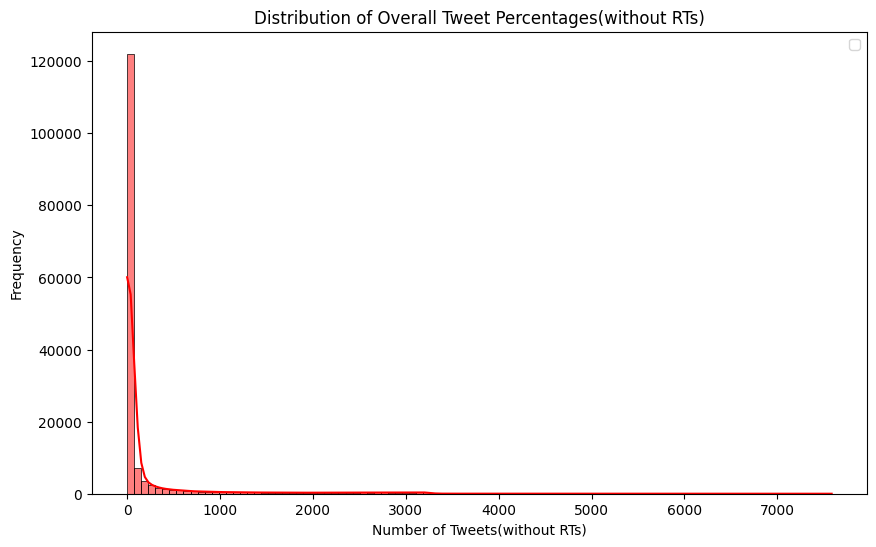

In [ ]:
###  a histogram that displays all users' tweet frequencies
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_without_rts_length'], kde=True, bins=100, color = 'red')
plt.xlabel('Number of Tweets(without RTs)')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Tweet Percentages(without RTs)')
# plt.axvline(x=threshold_value, color='red', linestyle='--', label='80th Percentile')

plt.legend()
plt.show()

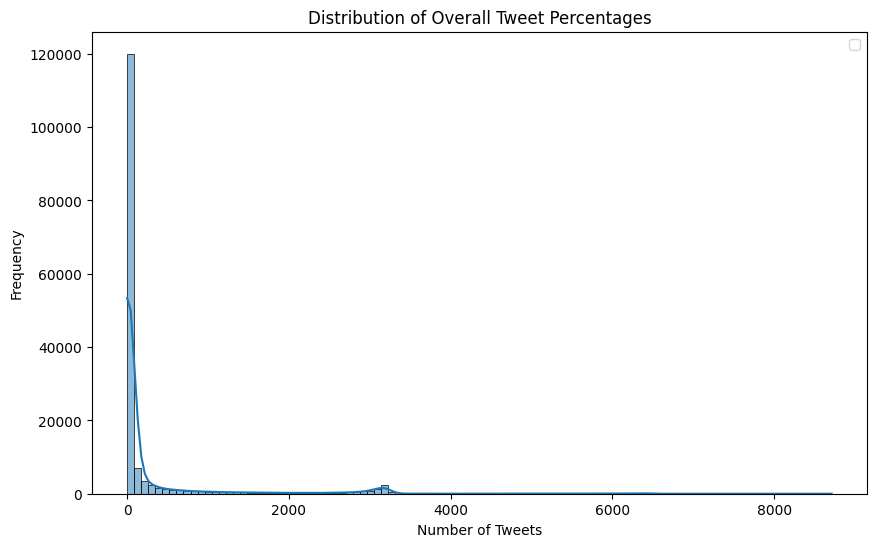

In [ ]:
###  a histogram that displays all users' tweet frequencies
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], kde=True, bins=100)
plt.xlabel('Number of Tweets')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Tweet Percentages')
# plt.axvline(x=threshold_value, color='red', linestyle='--', label='80th Percentile')

plt.legend()
plt.show()

In [ ]:
length_counts = df['tweet_without_rts_length'].value_counts()

In [ ]:
length_counts_df = length_counts.to_frame()
length_counts_df
#left is the number of tweet
#right column is the frequency it occurs in the data

,tweet_without_rts_length
1,34325
2,18443
3,8089
4,7478
6,4699
...,...
4000,1
3488,1
5062,1
5548,1


In [ ]:
length_counts = df['tweet_length'].value_counts()

In [ ]:
length_counts_df = length_counts.to_frame()
length_counts_df
#left is the number of tweets
#right column is the frequency it occurs in the data

,tweet_length
1,33592
2,18257
3,8051
4,7601
6,4660
...,...
4836,1
4052,1
4992,1
4140,1


Note:
- "The median Twitter user posts just two times a month, but the most prolific 10% of Twitter users in terms of tweet volume produce a median of 138 tweets monthly. In fact, this analysis estimates that the top 10% of tweeters are responsible for 80% of the tweets created by all U.S. adults on Twitter."
- https://www.pewresearch.org/internet/2019/04/24/sizing-up-twitter-users/#:~:text=The%20median%20Twitter%20user%20posts,all%20U.S.%20adults%20on%20Twitter.

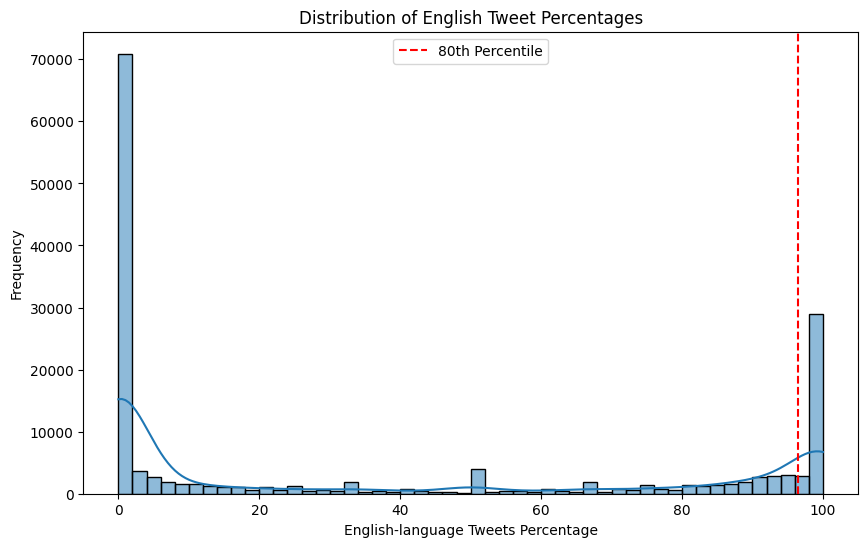

In [ ]:
## Visualization of English Tweet Percentages

### top 20% english-tweets threshold
threshold_value = np.percentile(eng_percentages, 80)

plt.figure(figsize=(10, 6))
sns.histplot(eng_percentages, kde=True, bins=50)
plt.xlabel('English-language Tweets Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of English Tweet Percentages')
plt.axvline(x=threshold_value, color='red', linestyle='--', label='80th Percentile')

plt.legend()
plt.show()

In [ ]:
### below are codes for different user cleaning thresholds used in round 1
### deprecated now, kept for reference purpose

In [ ]:
#If we go by 30+ tweet users and keep users whose english percentage is 80%+
df_30_80 = above_30_df[above_30_df['eng_percentage'] >= 80]
print(f"this leaves us with {len(df_30_80)} users({user_loss(len(df_30_80))}% loss) and {sum(df_30_80['tweet_length'])} tweets({tweet_loss(sum(df_30_80['tweet_length']))}% loss).")

this leaves us with 16085 users(89.55% loss) and 16226786 tweets(50.76% loss).


In [ ]:
#If we go by 30+ tweet users and keep users whose english percentage is 90%+
df_30_90 = above_30_df[above_30_df['eng_percentage'] >= 90]
print(f"this leaves us with {len(df_30_90)} users({user_loss(len(df_30_90))}% loss) and {sum(df_30_90['tweet_length'])} tweets({tweet_loss(sum(df_30_90['tweet_length']))}% loss).")

this leaves us with 11600 users(92.56% loss) and 11689335 tweets(65.4% loss).


In [ ]:
#If we go by 80+ tweet users and keep users whose english percentage is 80% +
df_80_80 = above_80_df[above_80_df['eng_percentage'] >= 80]
print(f"this leaves us with {len(df_80_80)} users({user_loss(len(df_80_80))}% loss) and {sum(df_80_80['tweet_length'])} tweets({tweet_loss(sum(df_80_80['tweet_length']))}% loss).")

this leaves us with 11464 users(92.65% loss) and 15698881 tweets(53.53% loss).


In [ ]:
#If we go by 80+ tweet users and keep users whose english percentage is 90% +
df_80_90 = above_80_df[above_80_df['eng_percentage'] >= 90]
print(f"this leaves us with {len(df_80_90)} users({user_loss(len(df_80_90))}% loss) and {sum(df_80_90['tweet_length'])} tweets({tweet_loss(sum(df_80_90['tweet_length']))}% loss).")

this leaves us with 8478 users(94.56% loss) and 11416808 tweets(66.2% loss).


# Layer 3 - Exclusing Non-US Users

In [ ]:
## function for converting UTC timestamps to Eastern Time (ET) or Eastern Daylight Time (EDT)
def convert_to_est_edt(timestamp):
    utc_time = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%fZ')
    utc_time = pytz.utc.localize(utc_time)

    eastern_time_zone = pytz.timezone('US/Eastern')
    est_time = utc_time.astimezone(eastern_time_zone)

    return est_time


# function for determining whether a tweet is posted within the time interval of 3am -6am
def is_within_narrow(timestamp):
    return 'yes' if (5 <= timestamp.hour < 6) and (timestamp.strftime('%p') == 'AM') else 'no'

def is_within_wide(timestamp):
    return 'yes' if (3 <= timestamp.hour < 8) and (timestamp.strftime('%p') == 'AM') else 'no'

def is_owl_or_bird(timestamp_list):
    night_percentage = sum([1 if (3 <= timestamp.hour < 5) and (timestamp.strftime('%p') == 'AM') else 0 for timestamp in timestamp_list])/len(timestamp_list)*100
    morning_percentage = sum([1 if (6 <= timestamp.hour < 8) and (timestamp.strftime('%p') == 'AM') else 0 for timestamp in timestamp_list])/len(timestamp_list)*100
    if night_percentage > 9 * morning_percentage or morning_percentage > 9 * night_percentage:
      return 'yes'
    else:
      return 'no'
    sum([1 for i in timestamp_list if i == 'yes'])/len(narrow_list)*100

## this is for handling lists of timestamps
def convert_list_to_est_edt(timestamp_list):
    return [convert_to_est_edt(timestamp) for timestamp in timestamp_list]

## this is for handling lists of timestamps
def cal_narrow_percentage(timestamp_list):
    narrow_list = [is_within_narrow(timestamp) for timestamp in timestamp_list]
    in_narrow_percent = sum([1 for i in narrow_list if i == 'yes'])/len(narrow_list)*100
    return in_narrow_percent

def cal_wide_percentage(timestamp_list):
    wide_list = [is_within_wide(timestamp) for timestamp in timestamp_list]
    in_wide_percent = sum([1 for i in wide_list if i == 'yes'])/len(wide_list)*100
    return in_wide_percent


In [ ]:
## test if time convertion works
timestamp = "2020-06-01T01:19:45.000Z"
converted_time = convert_to_est_edt(timestamp)
print(converted_time)

2020-05-31 21:19:45-04:00


In [ ]:
df_10_80['all_est_edt_time'] = df_10_80['all_time'].apply(convert_list_to_est_edt)

<ipython-input-34-7f378c410ab5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10_80['all_est_edt_time'] = df_10_80['all_time'].apply(convert_list_to_est_edt)


In [ ]:
# Display number of users before adopting tweeting time thresholds.
print(len(df_10_80))

25446


## df_30_80(loosest)

In [ ]:
df_10_80['percentage_in_narrow'] = df_10_80['all_est_edt_time'].apply(cal_narrow_percentage)
df_10_80['percentage_in_wide'] = df_10_80['all_est_edt_time'].apply(cal_wide_percentage)
df_10_80['owl_or_bird'] = df_10_80['all_est_edt_time'].apply(is_owl_or_bird)

<ipython-input-36-a6c27b4efd54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10_80['percentage_in_narrow'] = df_10_80['all_est_edt_time'].apply(cal_narrow_percentage)
<ipython-input-36-a6c27b4efd54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10_80['percentage_in_wide'] = df_10_80['all_est_edt_time'].apply(cal_wide_percentage)
<ipython-input-36-a6c27b4efd54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [ ]:
'''
#narrow time threshold 1 - keep users who never tweeted during the narrow time window(5-6 est)
df_30_80_narrow = df_30_80[df_30_80['percentage_in_narrow'] == 0]
show_user_loss(df_30_80_narrow)
'''

this leaves us with 5895 users(96.22% loss) and 2321273 tweets(93.13% loss).


In [ ]:
# THE LOOSEST OF LOOSEST
#narrow time threshold 2 - keep users who tweeted less than half of the time during the narrow time window(5-6 est)
df_10_80_narrow = df_10_80[df_10_80['percentage_in_narrow'] <= 50]
print(len(df_10_80_narrow))
# 15402

25431


In [ ]:
print(sum(df_10_80_narrow['all_tweet'].apply(len)))
#16025223

17353506


In [ ]:
print(sum(df_10_80_narrow['junk_tweets'].apply(len)))
# 4894594

5495398


In [ ]:
print(sum(df_10_80_narrow['non_junk_tweets'].apply(len)))
# 11130629

11858104


In [ ]:
df_10_80_narrow.head()

,author_id,unique_tweets,tweet_ids,all_lang,all_time,all_tweet,calculate_eng_percentage,eng_percentage,tweet_length,non_junk_tweets,junk_tweets,all_est_edt_time,percentage_in_narrow,percentage_in_wide,owl_or_bird
282828783,282828783,"{(282828783, 2011-04-20T17:27:30.000Z), (28282...","{654980068800884736, 105665715062841344, 69607...","[en, en, en, en, en, en, en, en, en, en, en]","[2015-10-16T11:19:52.000Z, 2011-08-22T15:40:44...",[RT @ARizzo44: I have two tickets for Tuesday'...,<bound method calculate_eng_percentage of <__m...,100.000000,11,[@HeyItsMeLaura because statistically it is un...,[RT @ARizzo44: I have two tickets for Tuesday'...,"[2015-10-16 07:19:52-04:00, 2011-08-22 11:40:4...",0.000000,9.090909,yes
323269759,323269759,"{(323269759, 2017-05-28T16:40:00.000Z), (32326...","{1288512490826076160, 1288511665823154176, 903...","[en, en, en, en, en, en, en, en, en, es, en, q...","[2020-07-29T16:31:31.000Z, 2020-07-29T16:28:15...",[@as_history @thiaozer @dbongino @as_history c...,<bound method calculate_eng_percentage of <__m...,90.697674,43,[@as_history @thiaozer @dbongino @as_history c...,[RT @JudyHibel: @SamMartin_6 Sent 35 lbs of do...,"[2020-07-29 12:31:31-04:00, 2020-07-29 12:28:1...",0.000000,0.000000,no
1012226096,1012226096,"{(1012226096, 2013-12-31T20:43:20.000Z), (1012...","{1593034351801171968, 1572699954266910720, 156...","[en, en, en, qme, qme, en, en, en, en, en, en,...","[2022-11-17T00:12:41.000Z, 2022-09-21T21:31:03...","[@decco88 A specimen of human physique, @Damie...",<bound method calculate_eng_percentage of <__m...,96.062992,127,"[@decco88 A specimen of human physique, @Damie...","[@BraydenCreation https://t.co/ukBatH8tAU, @Vi...","[2022-11-16 19:12:41-05:00, 2022-09-21 17:31:0...",3.937008,18.110236,no
272577655,272577655,"{(272577655, 2015-02-10T18:20:06.000Z), (27257...","{565213645702189056, 565213652215947265, 56521...","[en, en, en, en, en, en, en, en, en, en, en]","[2015-02-10T18:20:11.000Z, 2015-02-10T18:20:10...",[You will want to quit your job after reading ...,<bound method calculate_eng_percentage of <__m...,100.000000,11,[You will want to quit your job after reading ...,[],"[2015-02-10 13:20:11-05:00, 2015-02-10 13:20:1...",0.000000,0.000000,no
430140565,430140565,"{(430140565, 2017-08-16T11:50:12.000Z), (43014...","{1353716071803576320, 1353759283071102977, 115...","[en, en, en, en, en, en, en, en, en, en, en, e...","[2021-10-22T15:11:20.000Z, 2021-01-25T17:38:59...",[RT @JoeBiden: It’s time corporate America and...,<bound method calculate_eng_percentage of <__m...,100.000000,29,"[@TontoFlamingo @MichelleSweari9 Thanks, @Mich...",[RT @JoeBiden: It’s time corporate America and...,"[2021-10-22 11:11:20-04:00, 2021-01-25 12:38:5...",0.000000,10.344828,yes


In [ ]:
# save df to a csv
df_10_80_narrow.to_csv('cleaned_df_10_80_narrow_rt_excluded.csv', index=False)

In [ ]:
# inspect what' in the non-junk tweets
non_junk = list(df_10_80_narrow['non_junk_tweets'])

In [ ]:
non_junk[20]

['@barefootdiet  👏👏',
 'Happy 40th Shop old boy now @shoppo38 #party #time #soon http://t.co/U4MXmkXbcz',
 '@BrendanFevola25 @shoppo38 grog socks in out and about #lovethebeers #whowasthedrunkest http://t.co/T9ACGClHFb',
 '@BrendanFevola25 happy birthday Fev #gettingold #enjoyafewcoldones #haveagoodone',
 '@darbssalts what are you doing on Twitter #tooyoung #darbynoel',
 '@BrendanFevola25 I cried again #sook #lovethenotebook',
 '@CaitlinDugan @PRIME7NewsWagga',
 '@CaitlinDugan good reporting dugges',
 '@BrendanFevola25 well done on the appointment #gladyourstickingaround #yarra #cocoach #2015',
 "@CraigEdnie  that's gold #haha",
 'Me and my boy #browny #excitedmuch #lovehim #footy #finals #stalker http://t.co/1ahAfTr32I',
 'Good luck Yarra Boys &amp; A and B grades .... #goyarra #pigeons #grandfinal http://t.co/7g0cM1ucpi',
 "Cohen tells me this is who he's going for in the granny #goyarra #gofev #gopie #yarra #pigeons… http://t.co/XbAhWS4UiG",
 '@omfnl @YFNC_Pigeons congrats lozza #b&

# Creating dataset for fine-tuning Bert Classifier

https://huggingface.co/climatebert


- test run the 10k
- run BTM (50 - 100 topics) on 5k random tweets
---
- try to get the original set of keywords used by Greek friend
---
Oct 4th
- compute confusion matrix
---
Oct 25th
- compute tf+tfp+tn+fn; precision+recall+f-1


In [ ]:
positive_df = pd.read_csv('sample_positive_5000.csv')
negative_df = pd.read_csv('sample_negative_5000.csv')

In [ ]:
positive_df['label'] = 1
positive_df = positive_df[['text','label']]

In [ ]:
negative_df['label'] = 0
negative_df = negative_df[['text','label']]

In [ ]:
# Concatenate the datasets
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [ ]:
shuffled_df = shuffled_df.dropna()
shuffled_df

,text,label
0,[Guardian Science] Bolivia's second-largest la...,1
2,RT @ClimateNexus: Who should pay for damage as...,1
3,.@ananavarro #climatechange is REAL! cc @Tomas...,1
5,#AbkiBaar300Paar\nUnder the leadership of PM M...,1
6,PODCAST 02: The 25-Year Evolution of the #Sale...,0
...,...,...
9994,RT @NPR: Scientists appear to be self-censorin...,1
9995,Gah. Muscles don’t want to keep my body shape ...,0
9996,Good value...I am good with this move. :) ht...,0
9997,@Wish_gul you rock!!! I'm so lucky to have stu...,1


In [ ]:
#save shuffled data
shuffled_df.to_csv('231012_fine_tuning_10000.csv', index=False)

In [ ]:
# load dataset
shuffled_df = pd.read_csv('231012_fine_tuning_10000.csv')
data = Dataset.from_pandas(shuffled_df)

In [ ]:
data = data.train_test_split(test_size=0.2)

In [ ]:
data

Dataset({
    features: ['text', 'label'],
    num_rows: 9020
})

In [ ]:
# generate validation set
data_clean = data["train"].train_test_split(train_size=0.8, seed=42)
data_clean["validation"] = data_clean.pop("test")
data_clean["test"] = data["test"]
data_clean

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5772
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1444
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1804
    })
})

In [ ]:
#save splitted dataset
data_clean.save_to_disk('climate_finetuning_data')

Saving the dataset (0/1 shards):   0%|          | 0/5772 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1444 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1804 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk

data = load_from_disk('climate_finetuning_data')
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5772
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1444
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1804
    })
})

In [ ]:
###tokenize

model_name = "climatebert/distilroberta-base-climate-detector"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(dataset):
    return tokenizer(dataset["text"],padding="max_length", truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/5772 [00:00<?, ? examples/s]

Map:   0%|          | 0/1444 [00:00<?, ? examples/s]

Map:   0%|          | 0/1804 [00:00<?, ? examples/s]

In [ ]:
metric = evaluate.load("accuracy","f1")

In [ ]:
 def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
from transformers import AutoModelForSequenceClassification
model_name = "climatebert/distilroberta-base-climate-detector"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5772
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1444
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1804
    })
})

In [ ]:
train_data_cleaned = tokenized_datasets['train']
eval_data_cleaned = tokenized_datasets['validation']

In [ ]:
train_data_cleaned

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 5772
})

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= train_data_cleaned,
    eval_dataset= eval_data_cleaned,
    compute_metrics=compute_metrics,
    tokenizer = tokenizer
)
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.016700,0.010150,0.998615
2,0.010400,0.005498,0.999307
3,0.006500,0.006486,0.999307


TrainOutput(global_step=2166, training_loss=0.009441318903685937, metrics={'train_runtime': 316.5334, 'train_samples_per_second': 54.705, 'train_steps_per_second': 6.843, 'total_flos': 2293805475127296.0, 'train_loss': 0.009441318903685937, 'epoch': 3.0})

In [ ]:
## predict + compute metrics on the validation set
trainer.evaluate()

{'eval_loss': 0.0064856973476707935,
 'eval_accuracy': 0.9993074792243767,
 'eval_runtime': 7.9289,
 'eval_samples_per_second': 182.118,
 'eval_steps_per_second': 22.828,
 'epoch': 3.0}

In [ ]:
## predict + compute metrics on the test set
trainer.evaluate(eval_dataset=tokenized_datasets['test'])

{'eval_loss': 0.010314824990928173,
 'eval_accuracy': 0.9988913525498891,
 'eval_runtime': 10.0983,
 'eval_samples_per_second': 178.644,
 'eval_steps_per_second': 22.38,
 'epoch': 3.0}

In [ ]:
trainer.save_model("finetuned_climate_latest") #save fine-tuned model

In [ ]:
cd /content/drive/MyDrive/finetuned_climate_latest

/content/drive/MyDrive/finetuned_climate_latest


In [ ]:
ls

added_tokens.json  merges.txt         special_tokens_map.json  tokenizer.json     vocab.json
config.json        pytorch_model.bin  tokenizer_config.json    training_args.bin


In [ ]:
# test the fine-tuned trainer on the positive df(all climate tweets)
positive_df.head()

,id,text
0,9.861123e+17,RT @TheEconomist: A $15m prize is one more wea...
1,1.067910e+18,RT @LisPower1: CNN's press briefing fact-check...
2,2.351173e+09,#ff my girl J-dub on #climatechange #climate R...
3,1.004030e+18,As #bantheplastic trends this #WorldEnvironmen...
4,1.079371e+18,"@JulietHuddyTV So what do you, and other clima..."


In [ ]:
from datasets import load_metric
f1_metric = load_metric('f1')
precision_metric = load_metric('precision')

<ipython-input-51-e0fddf54ffd4>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1_metric = load_metric('f1')


In [ ]:
# Load the fine-tuned model and tokenizer
model_name = '/content/drive/MyDrive/finetuned_climate_latest'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenized_positive_df = positive_df['text'].apply(lambda x: tokenizer(x, padding=True, truncation=True, return_tensors="pt"))

In [ ]:
texts_to_predict = positive_df['text'].tolist()

In [ ]:
tokenized_texts = tokenizer(texts_to_predict , padding=True, truncation=True, return_tensors='pt', max_length=512)

In [ ]:
dataset = TensorDataset(tokenized_texts.input_ids, tokenized_texts.attention_mask)
dataloader = DataLoader(dataset, batch_size=8)


In [ ]:
predictions = []

for batch in dataloader:
    input_ids, attention_mask = batch
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(logits.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predictions.extend(predicted_class.cpu().numpy())


In [ ]:
len(predictions)

5000

In [ ]:
positive_df['predictions'].value_counts()
#only 2 of the positive cases are not catched by the model

1    4998
0       2
Name: predictions, dtype: int64

In [ ]:
# inspect wrong predictions
for i in positive_df[positive_df['predictions'] == 0].text:
  print(f"tweet:{i}")

tweet:RT @BetteMidler: Calling all #climatedeniers.  IT WAS 117 YESTERDAY IN LOS ANGELES!!!  IT'S GOING TO BE 103 TODAY.  ITS 8AM.  GIVE US A BRE…
tweet:@BetteMidler Fuck all #climatedeniers who:

-cite history's record high temps 
-say "U said weather ain't climate"
-say "Global temp only up .5 degree"
-say "supposed to be hot in summer"

None of these are valid contrarian points.

Proof you don't understand the science (or logical debate).


## Make Prediction on Filtered Tweets
- 50-80-wide threshold adopted here

In [ ]:
cd for_data_processing/

[Errno 2] No such file or directory: 'for_data_processing/'
/content/drive/.shortcut-targets-by-id/1fXHrAwlPV8OcV4hILOO-sKi-2N1cCxZ7/api_data/for_data_processing


### Pre-process a list of tweets for inference

In [ ]:
len(df_10_80_narrow)

25431

In [ ]:
def expand_tweets(df):
    new_rows = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        author_id = row['author_id']
        non_junk_tweets = row['non_junk_tweets']
        all_tweets = row['all_tweet']
        all_times = row['all_time']

        for tweet in non_junk_tweets:
            try:
                index = all_tweets.index(tweet)
                time = all_times[index]
                new_rows.append({'author_id': author_id, 'time': time, 'text': tweet})
            except ValueError:
                print(f"Tweet not found in all_tweet: {tweet}")
                print(f"all tweet is like: {all_tweets}")


    new_df = pd.DataFrame(new_rows)
    return new_df

new_tweet_df = expand_tweets(df_10_80_narrow)


100%|██████████| 25431/25431 [07:56<00:00, 53.37it/s]


In [ ]:
len(new_tweet_df)

11858104

In [ ]:
# remove duplicates
new_tweet_df = new_tweet_df.sort_values(by='time')

# remove duplicates while keeping the first occurrence, which is the earliest due to the sort
new_tweet_df = new_tweet_df.drop_duplicates(subset='text', keep='first')

In [ ]:
len(new_tweet_df)

11461819

In [ ]:
# save tweets data for predict
new_tweet_df.to_csv('Unique_Tweets_for_Predict_metadata.csv', index=False)

In [ ]:
# load tweet data for predict
df = pd.read_csv('Unique_Tweets_for_Predict_metadata.csv', lineterminator='\n')

# Remove Duplicates in Cleaned Tweets

In [ ]:
## load total_tweets from folder:'/for_data_processing'

In [ ]:
len(set(total_tweets))

11461819

In [ ]:
#count occurrences of each tweet
tweet_counts = Counter(total_tweets)

#duplicated (appear more than once) and have more than 8 words
duplicated_tweets = [tweet for tweet, count in tweet_counts.items() if count > 1 and len(tweet.split()) > 8]


In [ ]:
# draw a random sample of duplicated tweets
random_sample = random.sample(duplicated_tweets, 50)
random_sample


['#BBlogged: Featuring @Trindnails Moist &amp; Shiny #Nail Care http://t.co/xpJgBAJycD #Esthetics #VictoriaBC #Salon #Spa #NailArt #Manicure',
 'Hurray! I have finished "Citizens\' Health Is Paramount" task  in Big Business HD for iPad! http://t.co/3xjoAOKuMI #ipadgames #gameinsigh...',
 "Get in touch if you want a stunning #website for only £40 per month, that's almost the same as a mobile contract! #UKLunchHour",
 'Hurray! I have finished "Deficit" task  in Big Business HD for iPad! http://t.co/Ydv9dKYcHJ #gameinsight #ipad #ipadgames',
 'Adult #xxx #videos ( http://bit.ly/aEZEQq )  Help Please    19  (your place)',
 'Falling Price Auctions!\nBid, win and save on top brand-name products.\nhttp://t.co/n7FjLx5q',
 "Check out Women's Citizen for Humanity Jeans Size 27 https://t.co/ByGEFs5Iui @eBay",
 'Villa has been upgraded! Can you do the same? Download to find out! http://t.co/QuZH3fhofL #ipad,#ipadgames,#gameinsight',
 'Stats for the week have arrived. 1 new unfollower. Stats via ht

In [ ]:
top_50_tweets = tweet_counts.most_common(50)

In [ ]:
## inspect what's repeated the most
top_50_tweets

[("@PuffieSmoka_ivy's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.",
  3131),
 ("@R34_Ninetails's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.",
  2974),
 ('Good night all, sweet dreams', 692),
 ('Lol', 678),
 ('I’m currently playing the 7th Player on https://t.co/9kdEya1kON. Come and join me! https://t.co/6x4SF7pLaP',
  538),
 ('King of dark fantasy. Summon today. App Store: https://t.co/r9p0awqU9W Google Play: https://t.co/rOtgjiDVrY #DarkSummoner',
  528),
 ('@DonnieWahlberg Good morning #LoveEternal', 504),
 ('@dannywood Good morning Danny!', 503),
 ("@Mulun00's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.",
  455),
 ('Good morning', 442),
 ('😔', 437),
 ("@Shepierced's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.",
  388),
 ('Wow', 355),
 ('Looking for a mall just like this for your own? Ask m

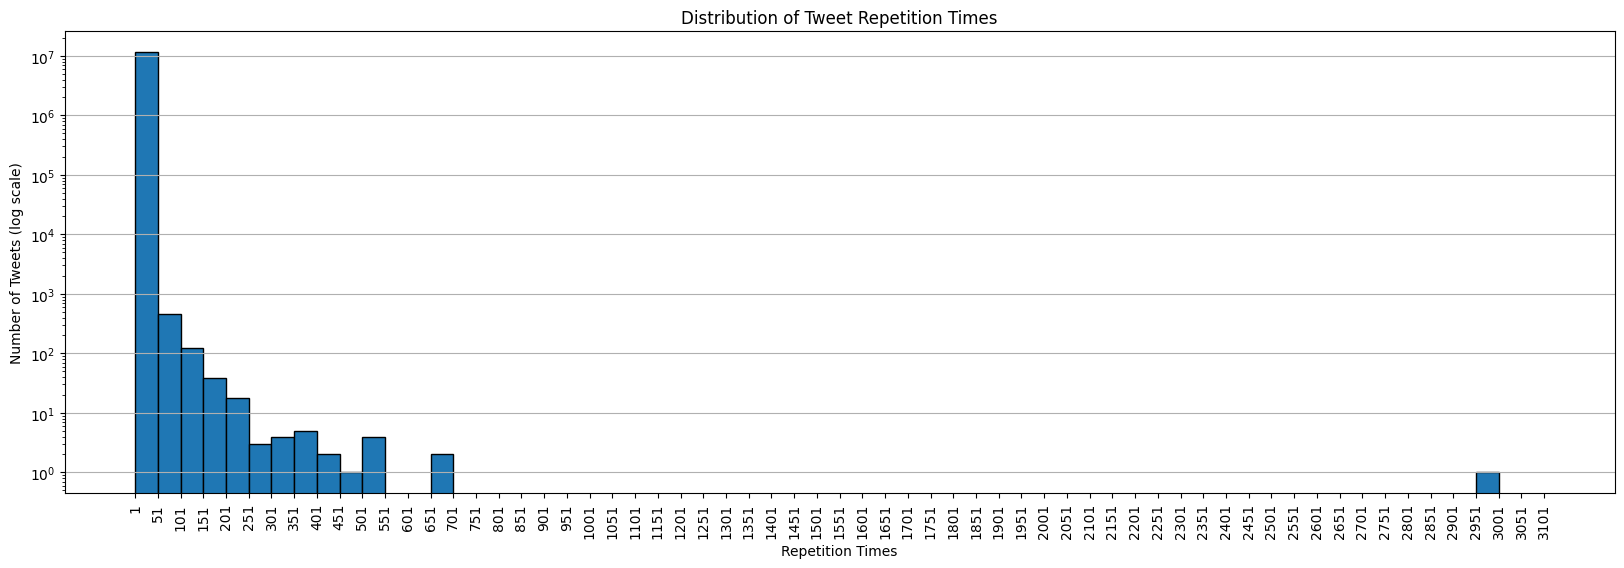

In [ ]:
plt.figure(figsize=(20, 6))
bins_range = range(1, max(repetition_counts) + 1, 50)
plt.hist(repetition_counts, bins=bins_range, edgecolor='black', log=True)
plt.title('Distribution of Tweet Repetition Times')
plt.xlabel('Repetition Times')
plt.ylabel('Number of Tweets (log scale)')
plt.xticks(bins_range)
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.grid(axis='y')

plt.show()


In [ ]:
# num of tweets that repeat only once
tweets_repeated_once = [tweet for tweet, count in tweet_counts.items() if count == 2]
num_tweets_repeated_once = len(tweets_repeated_once)

In [ ]:
print(num_tweets_repeated_once)

71678


In [ ]:
# num of tweets that repeat only once
tweets_repeated_1951_above = [tweet for tweet, count in tweet_counts.items() if 1950 <= count <= 3001]
num_tweets_repeated_once = len(tweets_repeated_1951_above)

In [ ]:
tweets_repeated_1951_above

["@R34_Ninetails's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more."]

# k-fold cross validation

#### prepare shuffled data

In [ ]:
cd for_data_processing/

/content/drive/.shortcut-targets-by-id/1fXHrAwlPV8OcV4hILOO-sKi-2N1cCxZ7/api_data/for_data_processing


In [ ]:
# read csv as df - these are the 'qualified' tweets - english and american
file_name = "processed_tweet_for_predict.csv"
df = pd.read_csv(file_name)

In [ ]:
df = df[df['text'].apply(lambda x: isinstance(x, str))]
#filter out the rows that are floats based on earlier inspection

In [ ]:
# Draw 10 splits of 5000 random tweets
combined_df_0 = pd.DataFrame()

for _ in range(10):
    split = df.sample(n=5000, replace=False)
    combined_df_0 = combined_df_0.append(split, ignore_index=True)

combined_df_0.info()
combined_df_0.head()

<ipython-input-17-7230a64ff8b2>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df_0 = combined_df_0.append(split, ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


,text
0,@PaulieEsther1 just watched Child's Play (terr...
1,💅💇👄💆💄💲✂🎨 http://t.co/3ag3cuwev2
2,RT @Real_Liam_Payne: @NiallOfficial SMASH IT I...
3,MLRT 😂
4,How bout them COWBOYS!!!


In [ ]:
combined_df_0['label'] = 0

In [ ]:
# draw 50k positive samples from climate dataset
# data_text_only.csv - the provided dataset from our Greek friend

,text,label
0,RT @RealTalkKim: People will assume that you d...,0
1,"[82] I just got 100 followers from this site, ...",0
2,"We need to stop making excuses, learn how to t...",0
3,"@levelsio Yeah, but how would one motivate peo...",0
4,My xbox is Making wierd noises?,0


In [ ]:
ls

all_tweets_from_top20_users.csv  eng_users.pkl                processed_tweet_for_predict.csv
all_tweets_from_top20_users.txt  model_outputs_top20.csv      top_20_Eng_ids.txt
data_text_only.csv               no_tweets_all_users.pkl
df_50_80_wide.csv                processed_top20_tweets.json


In [ ]:
# read csv as df
file_name = "data_text_only.csv"
df = pd.read_csv(file_name)

In [ ]:
# draw 10 splits of 5000 random tweets
combined_df = pd.DataFrame()

for _ in range(10):
    split = df.sample(n=5000, replace=False)
    combined_df = combined_df.append(split, ignore_index=True)

combined_df.info()
combined_df.head()

<ipython-input-20-0910192c7b06>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(split, ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  int64 
 1   text    50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


,id,text
0,565180930370056192,"No, #geoengineering is not a solution, we need..."
1,355931871932198912,How can we save the World from global warming?...
2,614352877549694976,Barack Obama interviews David Attenborough on ...
3,1029375537385418758,@theskindoctor13 Solar energy toh puch hi mat ...
4,1005108513637650432,RT @NickPonticello: Trump is skipping the G7 s...


In [ ]:
combined_df['label'] = 1

In [ ]:
combined_df_0

,text,label
0,@PaulieEsther1 just watched Child's Play (terr...,0
1,💅💇👄💆💄💲✂🎨 http://t.co/3ag3cuwev2,0
2,RT @Real_Liam_Payne: @NiallOfficial SMASH IT I...,0
3,MLRT 😂,0
4,How bout them COWBOYS!!!,0
...,...,...
49995,Yall be workin tho https://t.co/ynZmQhXlZp,0
49996,my pink feathered jimin is also gone???? WHAT ...,0
49997,Just the one new follower today found welcome ...,0
49998,@OMG_iFuckdYoHoe. Aha! Fat ass Nds Too Lose We...,0


In [ ]:
# concatenate the positive 50k and negative 50k to get 100k
merged_df = pd.concat([combined_df, combined_df_0], ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True) #shuffle the data

In [ ]:
shuffled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      50000 non-null   float64
 1   text    100000 non-null  object 
 2   label   100000 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
# save the shuffled df to a csv
file_name = "shuffled_100k_positive_and_negative_v1.csv"
shuffled_df.to_csv(file_name, index=False)

#### run trainer

In [ ]:
cd /content/drive/MyDrive/api_data/for_data_processing/

/content/drive/.shortcut-targets-by-id/1fXHrAwlPV8OcV4hILOO-sKi-2N1cCxZ7/api_data/for_data_processing


In [ ]:
filename = "shuffled_100k_positive_and_negative_v1.csv"
df = pd.read_csv(filename, dtype={'id': str, 'text': str, 'label': int}, lineterminator='\n')

In [ ]:
df['label'].value_counts()

0    50000
1    50000
Name: label, dtype: int64

In [ ]:
shuffled_df = df[['text','label']]

In [ ]:
len(shuffled_df)

100000

In [ ]:
##trim shuffled_df
# 2023.11.09. first attempt  - shuffled_df = shuffled_df.sample(n=5000, random_state=123)
# 2023.11.09 second attempt - create balanced sample
shuffled_positive = shuffled_df[shuffled_df['label'] == 1].sample(n=2500, random_state=123)
shuffled_negative = shuffled_df[shuffled_df['label'] == 0].sample(n=2500, random_state=123)
combined_df = pd.concat([shuffled_positive, shuffled_negative], ignore_index=True)

In [ ]:
combined_df['label'].value_counts()

1    2500
0    2500
Name: label, dtype: int64

In [ ]:
shuffled_df = combined_df

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
# initialize model and tokenizer
model_name = "climatebert/distilroberta-base-climate-detector"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

def tokenize_function(dataset):
    return tokenizer(dataset["text"],padding="max_length", truncation=True)

# tokenized_datasets = data.map(tokenize_function, batched=True)
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

(…)ector/resolve/main/tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

(…)climate-detector/resolve/main/vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

(…)climate-detector/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)ate-detector/resolve/main/tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

(…)-detector/resolve/main/added_tokens.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

(…)tor/resolve/main/special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


(…)limate-detector/resolve/main/config.json:   0%|          | 0.00/887 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [ ]:
print(next(model.parameters()).is_cuda)

True


In [ ]:
# load metrics
# accuracy = evaluate.load("accuracy")
# f1 = evaluate.load("f1")
# roc_auc_score = evaluate.load("roc_auc")
# cfm = evaluate.load("BucketHeadP65/confusion_matrix")

def compute_metrics(eval_pred):
    m1 = load_metric("accuracy")
    m2 = load_metric("f1")
    m3 = load_metric("roc_auc")
    m4 = evaluate.load("BucketHeadP65/confusion_matrix")
    m5 = load_metric("precision")
    m6 = load_metric("recall")


    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    probabilities = 1 / (1 + np.exp(-logits))

    accuracy = m1.compute(predictions=predictions, references=labels)['accuracy']
    f1 = m2.compute(predictions=predictions, references=labels)['f1']
    roc_auc_score = m3.compute(prediction_scores=probabilities[:, 1], references=labels)['roc_auc']
    cfm = m4.compute(predictions=predictions, references=labels)['confusion_matrix']
    cfm_str = int(''.join(map(str, cfm.flatten())))
    precision = m5.compute(predictions=predictions, references=labels)['precision']
    recall = m6.compute(predictions=predictions, references=labels)['recall']

    return {"accuracy": accuracy, "f1": f1, "roc_auc_score": roc_auc_score, 'cfm': cfm_str, "precision": precision, "recall": recall}


In [ ]:
# test if comput metirc function works
labels = np.array([0, 1, 1, 1, 0])
logits = np.array([[2.0, 1.0], [1.0, 3.0], [0.5, 0.7], [1.2, 1.4], [1.5, 1.3]])
labels = np.array([0, 1, 1, 1, 0])
eval_pred = (logits, labels)
results = compute_metrics(eval_pred)
print(results)

<ipython-input-64-0e0bad4a128b>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  m1 = load_metric("accuracy")


{'accuracy': 1.0, 'f1': 1.0, 'roc_auc_score': 0.6666666666666666, 'cfm': 2003, 'precision': 1.0, 'recall': 1.0}


In [ ]:
# initialize results df

random_seeds = [random.randint(0, 2**32-1) for _ in range(10)]

results_df = pd.DataFrame(columns=['Fold','Accuracy', 'auroc', 'f1',
                                   'cfm',
                                   'precision', 'recall']) #'cfm' temporarily removed
seeds = []
counter = 1

for seed in random_seeds:
  train_df, test_df = train_test_split(shuffled_df, test_size=.2, random_state = seed, stratify = shuffled_df['label'])
  train_df, val_df = train_test_split(train_df, test_size=.2, random_state = seed,stratify = train_df['label'])
  print("Fold: ", counter)
  print("Fold shape train", train_df.shape)
  print("Fold shape val", val_df.shape)
  print("Fold shape test", test_df.shape)

  #create dataset object from current split
  train_dataset = Dataset.from_pandas(train_df)
  val_dataset = Dataset.from_pandas(val_df)
  test_dataset = Dataset.from_pandas(test_df)

  # tokenize
  tokenized_train = train_dataset.map(tokenize_function, batched=True)
  tokenized_val = val_dataset.map(tokenize_function, batched=True)
  tokenized_test = test_dataset.map(tokenize_function, batched=True)

  # create separate output dir for each model
  fold_output_dir = f"kfold_trainer/model_fold_{counter}"

  # define training arguments
  training_args = TrainingArguments(output_dir=fold_output_dir,
                                    overwrite_output_dir=True,
                                    evaluation_strategy="epoch")

  # train
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= tokenized_train,
    eval_dataset = tokenized_val,
    compute_metrics=compute_metrics,
    tokenizer = tokenizer
    )
  trainer.train()


  # Evaluate current model on the test set
  eval_results = trainer.evaluate(eval_dataset = tokenized_test)

  # saved model
  model.save_pretrained(fold_output_dir)
  tokenizer.save_pretrained(fold_output_dir)

  # save eval results
  results_data = {
      'Fold': counter,
      'Accuracy': eval_results.get('eval_accuracy', None),
      'auroc': eval_results.get('eval_roc_auc_score', None),
      'f1': eval_results.get('eval_f1', None),
      "cfm": eval_results.get('eval_confusion_matrix', None),
      "precision": eval_results.get('eval_precision', None),
      "recall": eval_results.get('eval_recall', None)
  }

  results_df = results_df.append(results_data, ignore_index=True)
  print(results_df)

  # Increment the fold counter
  counter += 1
  break
# save results
results_df.to_csv("10_splits_cross_validation_results.csv", index=False)



Fold:  1
Fold shape train (3200, 2)
Fold shape val (800, 2)
Fold shape test (1000, 2)


Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc Score,Cfm,Precision,Recall
1,No log,0.014773,0.998750,0.998752,0.998425,39910400,0.997506,1.000000
2,0.009200,0.015683,0.998750,0.998752,0.999122,39910400,0.997506,1.000000
3,0.000000,0.015939,0.998750,0.998752,0.999319,39910400,0.997506,1.000000


<ipython-input-66-93c524206bb7>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results_data, ignore_index=True)


   Fold  Accuracy  auroc        f1  cfm  precision  recall
0   1.0     0.999    1.0  0.999001  NaN   0.998004     1.0


In [ ]:
ls kfold_trainer/model_fold_1/

added_tokens.json  config.json        runs/                    tokenizer.json
checkpoint-1000/   merges.txt         special_tokens_map.json  vocab.json
checkpoint-500/    model.safetensors  tokenizer_config.json


In [ ]:
eval_results

{'eval_loss': 1.948928547790274e-05,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_roc_auc_score': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_runtime': 8.3042,
 'eval_samples_per_second': 120.422,
 'eval_steps_per_second': 15.053,
 'epoch': 3.0}

### fine-tuned model makes inference on qualified data

In [ ]:
# functions for batch prediction
def predict_batch(texts, model, tokenizer, device):
    tokenized_batch = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_batch = {k: v.to(device) for k, v in tokenized_batch.items()}  # Move to GPU

    with torch.no_grad():
        outputs = model(**tokenized_batch)

    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    return predictions

def predict_chunk(df_chunk, model, tokenizer, device, batch_size=32):
    predictions = []
    for start in range(0, len(df_chunk), batch_size):
        batch_texts = df_chunk['text'][start:start + batch_size].tolist()
        batch_predictions = predict_batch(batch_texts, model, tokenizer, device)
        predictions.extend(batch_predictions)
    df_chunk['prediction'] = predictions
    return df_chunk

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_path = "/content/drive/MyDrive/api_data/for_data_processing/kfold_trainer/model_fold_1"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)

df_iterator = pd.read_csv("/content/drive/MyDrive/api_data/for_data_processing/processed_tweet_No_RTs_for_predict.csv", chunksize=50000)


for i, df_chunk in enumerate(tqdm(df_iterator, desc="Processing Chunks")):
    df_chunk_processed = predict_chunk(df_chunk, model, tokenizer, device)
    df_chunk_processed.to_csv(f'/content/drive/MyDrive/api_data/for_data_processing/inference_results_no_RTs/processed_tweets_chunk_{i}.csv', index=False)
    del df_chunk_processed
    torch.cuda.empty_cache()

Using device: cuda


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Processing Chunks: 21it [09:13, 26.36s/it]


TypeError: ignored

In [ ]:
cd inference_results_no_RTs

[Errno 2] No such file or directory: 'inference_results_no_RTs'
/content/drive/.shortcut-targets-by-id/1fXHrAwlPV8OcV4hILOO-sKi-2N1cCxZ7/api_data/for_data_processing/inference_results_no_RTs


In [ ]:
combined_df['prediction'].value_counts()

0    1049282
1        718
Name: prediction, dtype: int64

## testing

In [ ]:
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

# Define the path where you saved the fine-tuned model
path = "/content/drive/MyDrive/huggingface_models/fine_tuned_climate"

tokenizer = AutoTokenizer.from_pretrained(path, max_len=512)
model = AutoModelForSequenceClassification.from_pretrained(path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(path, model_type="model_type_used_for_finetuning", max_len=512)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(path, model_type="model_type_used_for_finetuning")

# Specify the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Define the path where you saved the fine-tuned model
path = "/content/drive/MyDrive/huggingface_models/fine_tuned_climate"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(path, model_type="model_type_used_for_finetuning", max_len=512)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(path, model_type="model_type_used_for_finetuning")

# Example: Tokenize and inference
text = ""
tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
outputs = model(**tokens)
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

print(f"Predicted class: {predicted_class}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Predicted class: 0


In [ ]:
tokenized_datasets['test']

NameError: ignored

In [ ]:
# Convert input ids and test labels to PyTorch tensors
input_ids = torch.tensor(tokenized_datasets['test']['input_ids'])
attention_mask = torch.tensor(tokenized_datasets['test']['attention_mask'])
test_labels = torch.tensor(tokenized_datasets['test']['label'])  # Convert to a tensor

# Use the model for inference
with torch.no_grad():
    # Pass input_ids and attention_mask as part of a dictionary
    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

# Convert logits to probabilities if needed
probabilities = torch.softmax(logits, dim=1)

# Calculate predictions based on the highest probability
predictions = np.argmax(probabilities, axis=-1)

# Calculate the accuracy metric using your custom evaluate library
accuracy = metric.compute(predictions=predictions, references=test_labels)

print("Accuracy:", accuracy)


drive/  sample_data/


In [ ]:
'''old codes'''

In [ ]:
# Apply the conversion function to convert UTC to EDT
df.loc[:, 'est_edt_timestamp'] = df['timestamp'].apply(convert_to_est_edt)

In [ ]:
# Create two columns to store yes vs. no in two time windows
df.loc[:, 'is_within_narrow'] = df['est_edt_timestamp'].apply(is_within_narrow)
df.loc[:, 'is_within_wide'] = df['est_edt_timestamp'].apply(is_within_wide)

In [ ]:
# Calculate the proportion of 'yes' when applying the narrow time interval
percentage_yes_narrow = df.groupby('ID')['is_within_narrow'].apply(lambda x: (x == 'yes').mean() * 100)

In [ ]:
percentage_yes_narrow.value_counts()[:10]

0.000000      27385
100.000000      205
50.000000       148
33.333333        97
20.000000        80
25.000000        77
16.666667        65
14.285714        54
12.500000        47
8.333333         41
10.000000        36
Name: is_within_narrow, dtype: int64

In [ ]:
# Calculate the proportion of 'yes' when applying the wide time interval
percentage_yes_wide = df.groupby('ID')['is_within_wide'].apply(lambda x: (x == 'yes').mean() * 100)

In [ ]:
percentage_yes_wide.value_counts()[:10]

0.000000      21905
100.000000     1466
50.000000       718
33.333333       451
25.000000       333
20.000000       205
16.666667       200
66.666667       154
14.285714       147
40.000000       106
12.500000        98
11.111111        86
10.000000        69
Name: is_within_wide, dtype: int64

In [ ]:
# Calculate the proportion of each
percentage_yes_all = df.groupby('ID')['is_within_narrow','is_within_wide'].apply(lambda x: (x == 'yes').mean() * 100)

<ipython-input-108-9d54928eb8c8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  percentage_yes_all = df.groupby('ID')['is_within_narrow','is_within_wide'].apply(lambda x: (x == 'yes').mean() * 100)


In [ ]:
percentage_yes_df = percentage_yes_all.reset_index()

In [ ]:
percentage_yes_df

,ID,is_within_narrow,is_within_wide
0,100000376,0.0,0.000000
1,1000148725,0.0,0.000000
2,1000203690,0.0,11.111111
3,1000207879,0.0,0.000000
4,1000265286,0.0,0.000000
...,...,...,...
31184,999266263,0.0,100.000000
31185,999415554,0.0,0.000000
31186,999577340,0.0,0.000000
31187,99987334,0.0,0.000000


- scattor plot of the two time zones - order the size of points by frequency

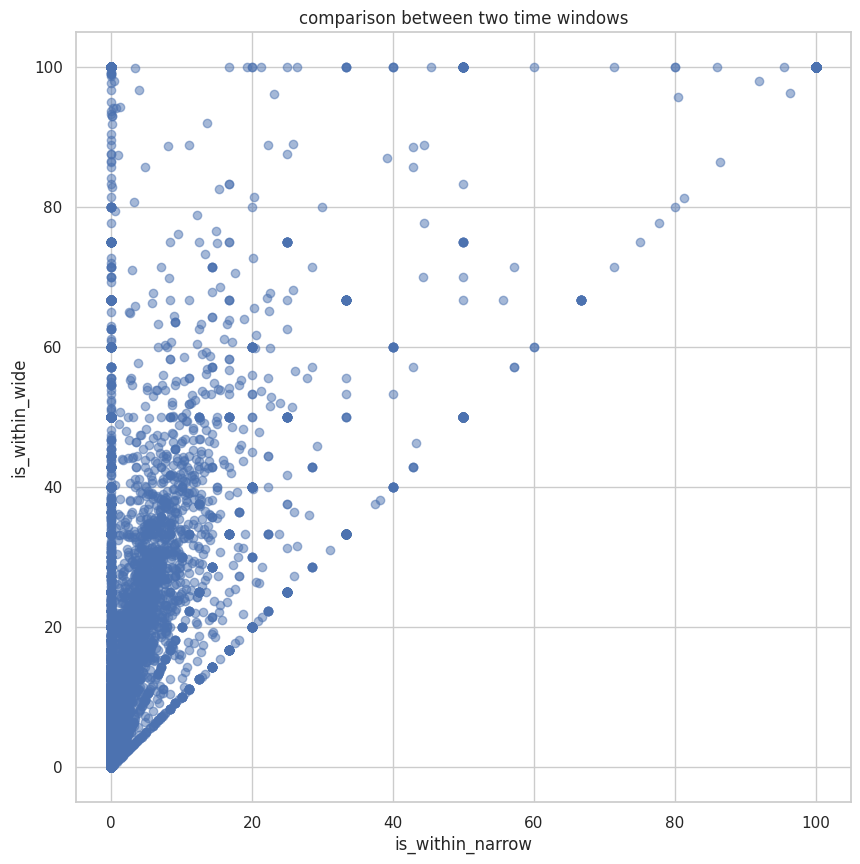

In [ ]:
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.scatter(percentage_yes_df['is_within_narrow'], percentage_yes_df['is_within_wide'], alpha=0.5)  # alpha controls transparency

# Add labels and title
plt.xlabel('is_within_narrow')
plt.ylabel('is_within_wide')
plt.title('comparison between two time windows')

# Show the plot
plt.grid(True)
plt.show()

- tbd:
  - flip the order of the filters: after every filter we have a count of left users and tweets.
  - do a more stringent and a loose filter for each threshold.
  1. active user (50 vs. 100?)
  2. change percentile of eng lang to percentage 80% vs 90% - this could make the biggest dif
  3. time window: keep <50% in the wide interval

In [ ]:
'''this is from before'''

In [ ]:
'''DON'T RUN'''
### Below is the stats before enlarging the time interval to include West Coast time
percentage_yes_df['percentage_yes'].value_counts()

0.000000      24220
100.000000      955
50.000000       433
33.333333       302
25.000000       240
              ...  
27.247537         1
37.542556         1
1.290323          1
5.980066          1
1.606426          1
Name: percentage_yes, Length: 2548, dtype: int64

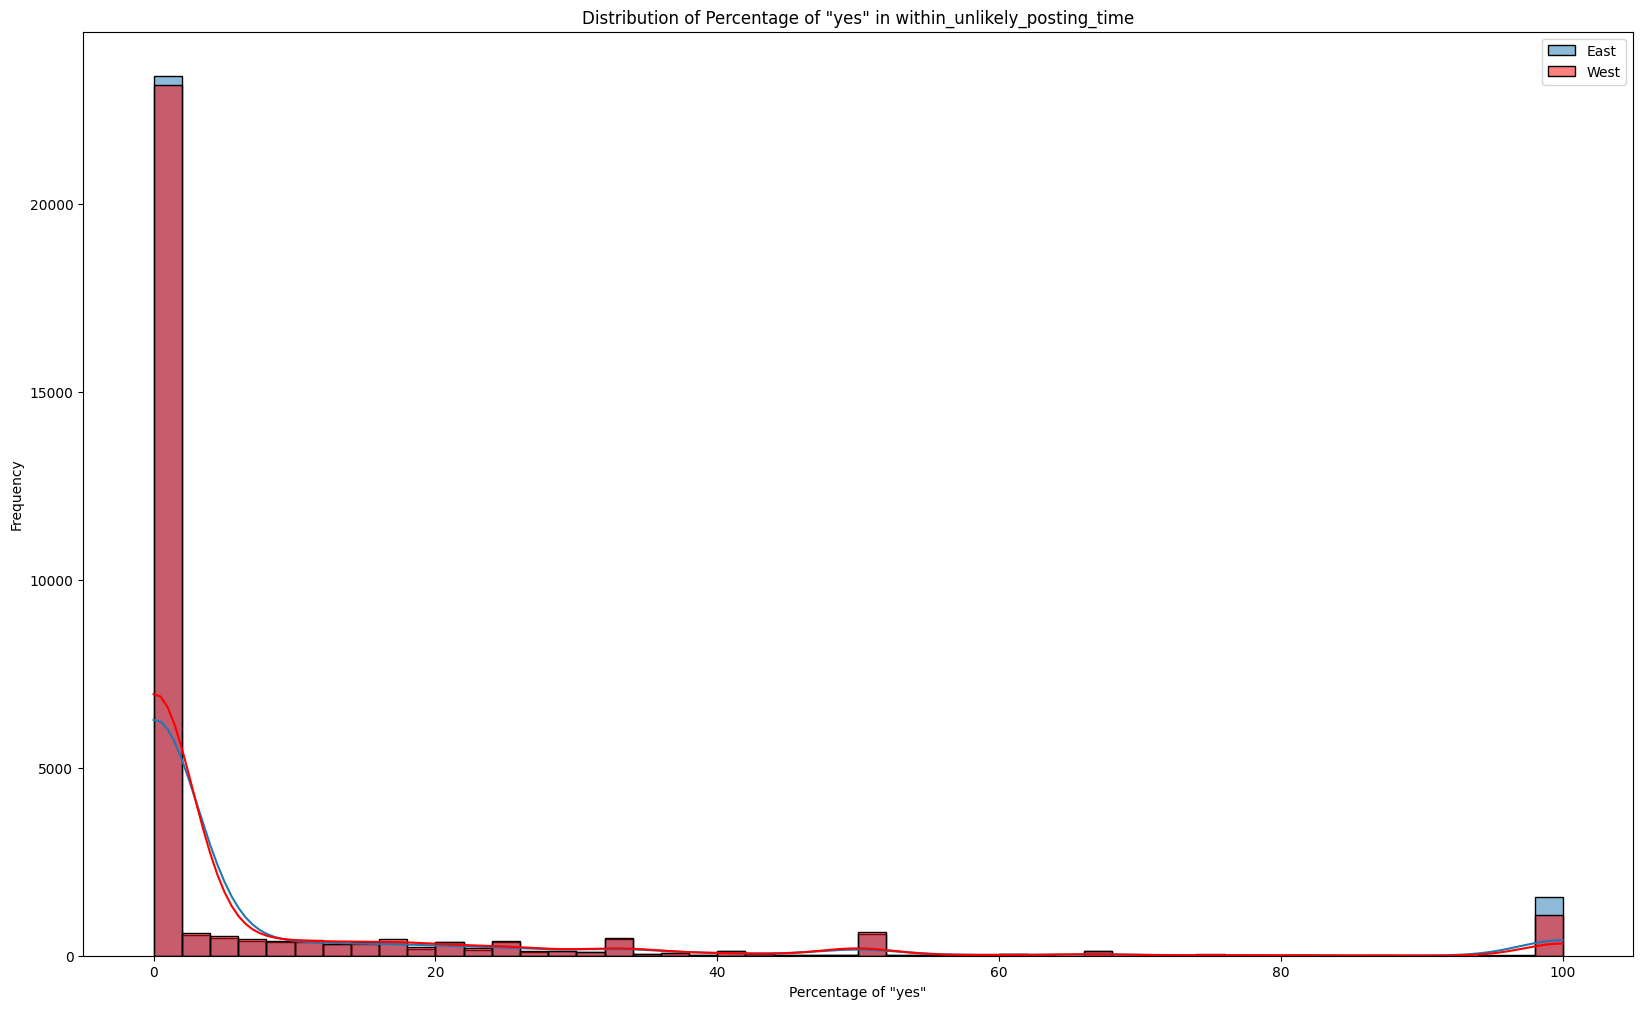

In [ ]:
plt.figure(figsize=(20, 12))

sns.histplot(percentage_yes['within_unlikely_posting_time_east'], kde=True, bins=50, label='East')
sns.histplot(percentage_yes['within_unlikely_posting_time_west'], kde=True, bins=50, label='West', color = 'red')

plt.xlabel('Percentage of "yes"')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of "yes" in within_unlikely_posting_time')
plt.legend()  # Show legend with labels
plt.show()

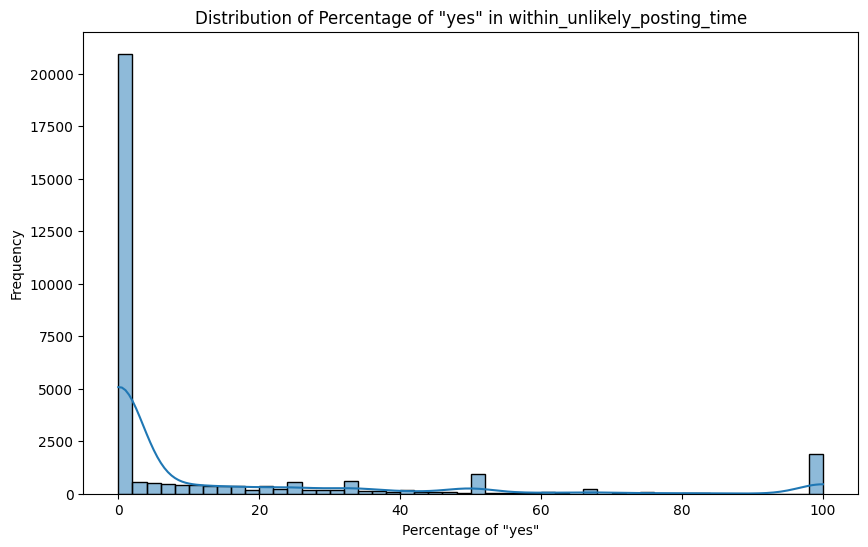

In [ ]:
# Plotting the distribution
plt.figure(figsize=(10,6))
sns.histplot(percentage_yes, kde=True, bins=50)
plt.xlabel('Percentage of "yes"')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of "yes" in within_unlikely_posting_time')
plt.show()

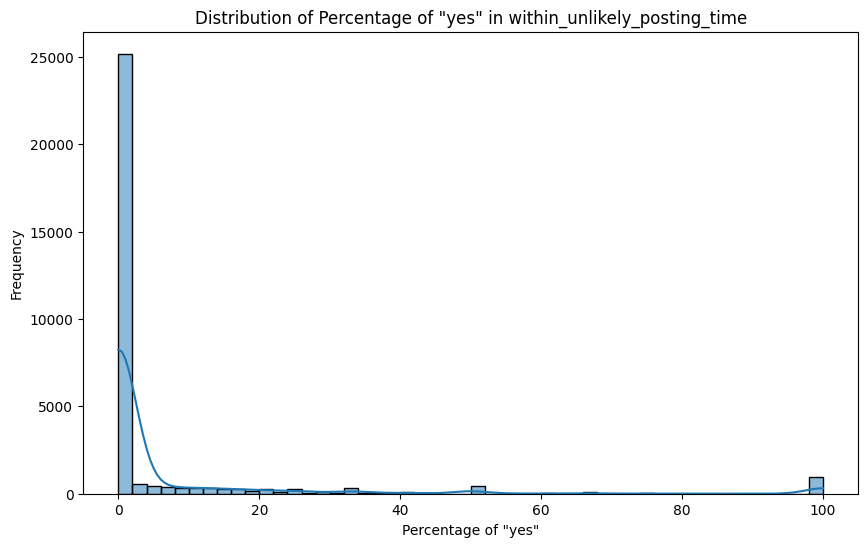

In [ ]:
'''DON'T RUN'''
### Below is the stats before enlarging the time interval to include West Coast time
# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(percentage_yes, kde=True, bins=50)
plt.xlabel('Percentage of "yes"')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of "yes" in within_unlikely_posting_time')
plt.show()

# Create dataset for manual labeling



01102024

few-shot classification
llama2

- use dimitris data & dictonary method

In [ ]:
# load 'qualified' tweets - english-speaking and american and active
file_name = "processed_tweet_No_RTs_for_predict.csv"
df = pd.read_csv(file_name)

In [ ]:
len(df)

11913868

In [ ]:
dup = df.duplicated()

In [ ]:
# the number of duplicated tweets - around 13%
duplicate_rows = df[dup]
len(duplicate_rows)

1636147

In [ ]:
# read csv as df
file_name = "data_text_only.csv"
df_dimitris = pd.read_csv(file_name)

In [ ]:
df.head()

,text
0,@as_history @thiaozer @dbongino @as_history co...
1,"@freeinaus @dbongino tried to watch the video,..."
2,@J0SHSTEWART am doing the binge thing on #Shoo...
3,@jojoh888 Absolutely! A knuckle sammich to the...
4,@Stevenwhirsch99 Get well and get back to work...


In [ ]:
df_dimitris.head()

,id,text
0,6132,my dentist just explained to me that global wa...
1,13275,I used to be a big fan of global warming.
2,23160,reading the economist and looking forward to g...
3,57868,Sitting outside on my patio in a t-shirt in sf...
4,304553,"Name drop alert: listening to Tony Blair, at w..."


In [ ]:
# draw 500 random tweets from each DataFrame
df_sample = df.sample(n=500, random_state=1)
df_dimitris_sample = df_dimitris.sample(n=500, random_state=1)

# combine the two random groups of tweets
combined_df = pd.concat([df_sample, df_dimitris_sample], ignore_index=True)
combined_df = combined_df.drop('id', axis=1)

# shuffle and create 2 files
shuffled_df = combined_df.sample(frac=1, random_state=1).reset_index(drop=True)

# for labeling
shuffled_df['is_climate'] = ''
shuffled_df['note'] = ''

df_part1 = shuffled_df.iloc[:500]
df_part2 = shuffled_df.iloc[500:]

new_dir = 'for_labeling'
new_dir_path = os.path.join(os.getcwd(), new_dir)
os.makedirs(new_dir_path, exist_ok=True)

# save the two csvs into the dir
df_part1.to_csv(os.path.join(new_dir_path, 'tweets_N500_1.csv'), index=False, columns=['text', 'is_climate', 'note'])
df_part2.to_csv(os.path.join(new_dir_path, 'tweets_N500_2.csv'), index=False, columns=['text', 'is_climate', 'note'])



In [ ]:
# Return the paths of the new csv files
csv_part1_path = os.path.join(new_dir, 'tweets_part1.csv')
csv_part2_path = os.path.join(new_dir, 'tweets_part2.csv')

csv_part1_path, csv_part2_path

('/for_labeling/tweets_part1.csv', '/for_labeling/tweets_part2.csv')


# Load tweets by top20 percentile English-speaking users





In [ ]:
cd for_data_processing/

/content/drive/.shortcut-targets-by-id/1fXHrAwlPV8OcV4hILOO-sKi-2N1cCxZ7/api_data/for_data_processing


In [ ]:
with open("processed_top20_tweets.json", "r") as json_file:
    processed_top20_tweets = json.load(json_file)

In [ ]:
len(processed_top20_tweets) ##num of tweets from the top 20% users - should be 3294240

3294240


### compute time window for the top 20 users
- create a window that represents us users -  e.g. 8am - midnight(assume to be east coast users) + alaska/hawaii
- 0/1 flag for each user  to be in and out of the each user
- what % of each user tweet outside that window

1. figure out the window (sleep patterns of the US users)(https://www.science.org/doi/full/10.1126/science.1202775?casa_token=16u4IlHAwQAAAAAA%3ABKv9bMIPPxTXMOblyUyr8nJ2dAcrSE0YDOUHSwpTHuNIiHYHEB1OT1DopsZX00nzKRZjTYignrPgdtE
https://journals.sagepub.com/doi/full/10.1177/2053951715606164


2. what is the threshold(depends on the distribution we get)

==
make time window broader - midnight cali(2/3am) - 9am eastern time
+ re-implement English evaluation by proficiency score

- detecting spam
  - one way is to look at percentage of duplicate tweets of user

  pytorch + keras + tensorflow

In [ ]:
df = pd.DataFrame(processed_top20_tweets)
df = df.iloc[:-1] # exclude header

In [ ]:
## function for converting UTC timestamps to Eastern Time (ET) or Eastern Daylight Time (EDT)
def convert_to_est_edt(timestamp):
    utc_time = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%fZ')
    utc_time = pytz.utc.localize(utc_time)

    eastern_time_zone = pytz.timezone('US/Eastern')
    est_time = utc_time.astimezone(eastern_time_zone)

    return est_time

# function for determining whether a tweet is posted within the time interval of 3am -6am
def is_within_narrow(timestamp):
    return 'yes' if (5 <= timestamp.hour < 6) and (timestamp.strftime('%p') == 'AM') else 'no'

def is_within_wide(timestamp):
    return 'yes' if (3 <= timestamp.hour < 8) and (timestamp.strftime('%p') == 'AM') else 'no'


In [ ]:
## test if convertion works
timestamp = "2020-06-01T01:19:45.000Z"
converted_time = convert_to_est_edt(timestamp)
print(converted_time)

2020-05-31 21:19:45-04:00


In [ ]:
# Apply the conversion function to convert UTC to EDT
df.loc[:, 'est_edt_timestamp'] = df['timestamp'].apply(convert_to_est_edt)

In [ ]:
# Create two columns to store yes vs. no in two time windows
df.loc[:, 'is_within_narrow'] = df['est_edt_timestamp'].apply(is_within_narrow)
df.loc[:, 'is_within_wide'] = df['est_edt_timestamp'].apply(is_within_wide)

In [ ]:
# Calculate the proportion of 'yes' when applying the narrow time interval
percentage_yes_narrow = df.groupby('ID')['is_within_narrow'].apply(lambda x: (x == 'yes').mean() * 100)

In [ ]:
percentage_yes_narrow.value_counts()[:10]

0.000000      27385
100.000000      205
50.000000       148
33.333333        97
20.000000        80
25.000000        77
16.666667        65
14.285714        54
12.500000        47
8.333333         41
10.000000        36
Name: is_within_narrow, dtype: int64

In [ ]:
# Calculate the proportion of 'yes' when applying the wide time interval
percentage_yes_wide = df.groupby('ID')['is_within_wide'].apply(lambda x: (x == 'yes').mean() * 100)

In [ ]:
percentage_yes_wide.value_counts()[:10]

0.000000      21905
100.000000     1466
50.000000       718
33.333333       451
25.000000       333
20.000000       205
16.666667       200
66.666667       154
14.285714       147
40.000000       106
12.500000        98
11.111111        86
10.000000        69
Name: is_within_wide, dtype: int64

In [ ]:
# Calculate the proportion of each
percentage_yes_all = df.groupby('ID')['is_within_narrow','is_within_wide'].apply(lambda x: (x == 'yes').mean() * 100)

<ipython-input-108-9d54928eb8c8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  percentage_yes_all = df.groupby('ID')['is_within_narrow','is_within_wide'].apply(lambda x: (x == 'yes').mean() * 100)


In [ ]:
percentage_yes_df = percentage_yes_all.reset_index()

In [ ]:
percentage_yes_df

,ID,is_within_narrow,is_within_wide
0,100000376,0.0,0.000000
1,1000148725,0.0,0.000000
2,1000203690,0.0,11.111111
3,1000207879,0.0,0.000000
4,1000265286,0.0,0.000000
...,...,...,...
31184,999266263,0.0,100.000000
31185,999415554,0.0,0.000000
31186,999577340,0.0,0.000000
31187,99987334,0.0,0.000000


- scattor plot of the two time zones - order the size of points by frequency

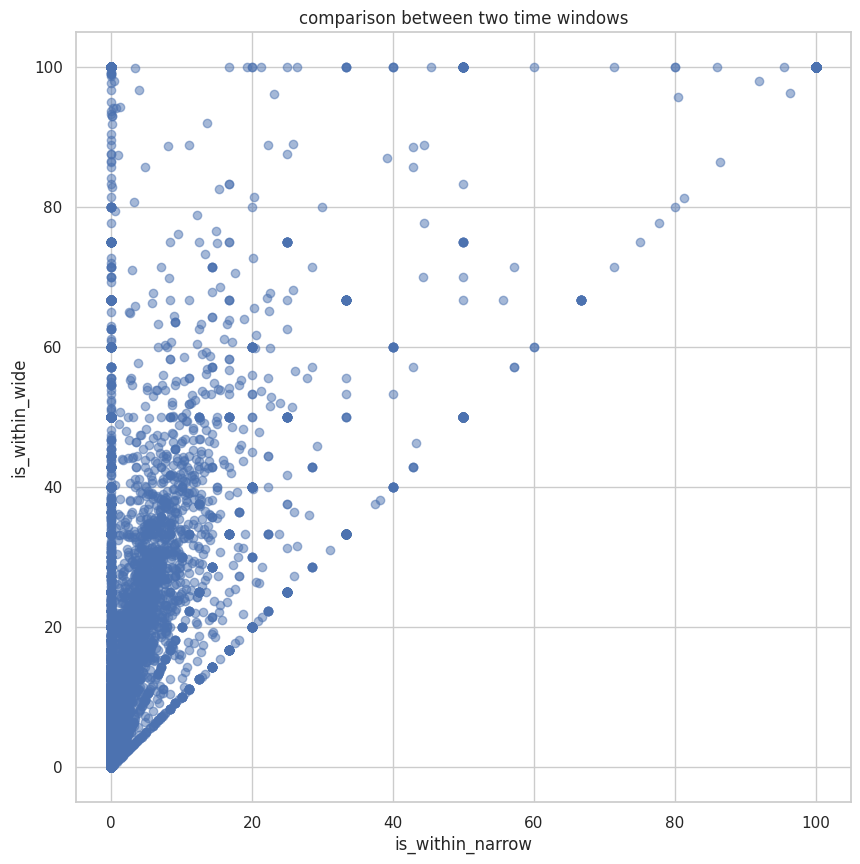

In [ ]:
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.scatter(percentage_yes_df['is_within_narrow'], percentage_yes_df['is_within_wide'], alpha=0.5)  # alpha controls transparency

# Add labels and title
plt.xlabel('is_within_narrow')
plt.ylabel('is_within_wide')
plt.title('comparison between two time windows')

# Show the plot
plt.grid(True)
plt.show()

- tbd:
  - flip the order of the filters: after every filter we have a count of left users and tweets.
  - do a more stringent and a loose filter for each threshold.
  1. active user (50 vs. 100?)
  2. change percentile of eng lang to percentage 80% vs 90% - this could make the biggest dif
  3. time window: keep <50% in the wide interval

In [ ]:
'''this is from before'''

In [ ]:
'''DON'T RUN'''
### Below is the stats before enlarging the time interval to include West Coast time
percentage_yes_df['percentage_yes'].value_counts()

0.000000      24220
100.000000      955
50.000000       433
33.333333       302
25.000000       240
              ...  
27.247537         1
37.542556         1
1.290323          1
5.980066          1
1.606426          1
Name: percentage_yes, Length: 2548, dtype: int64

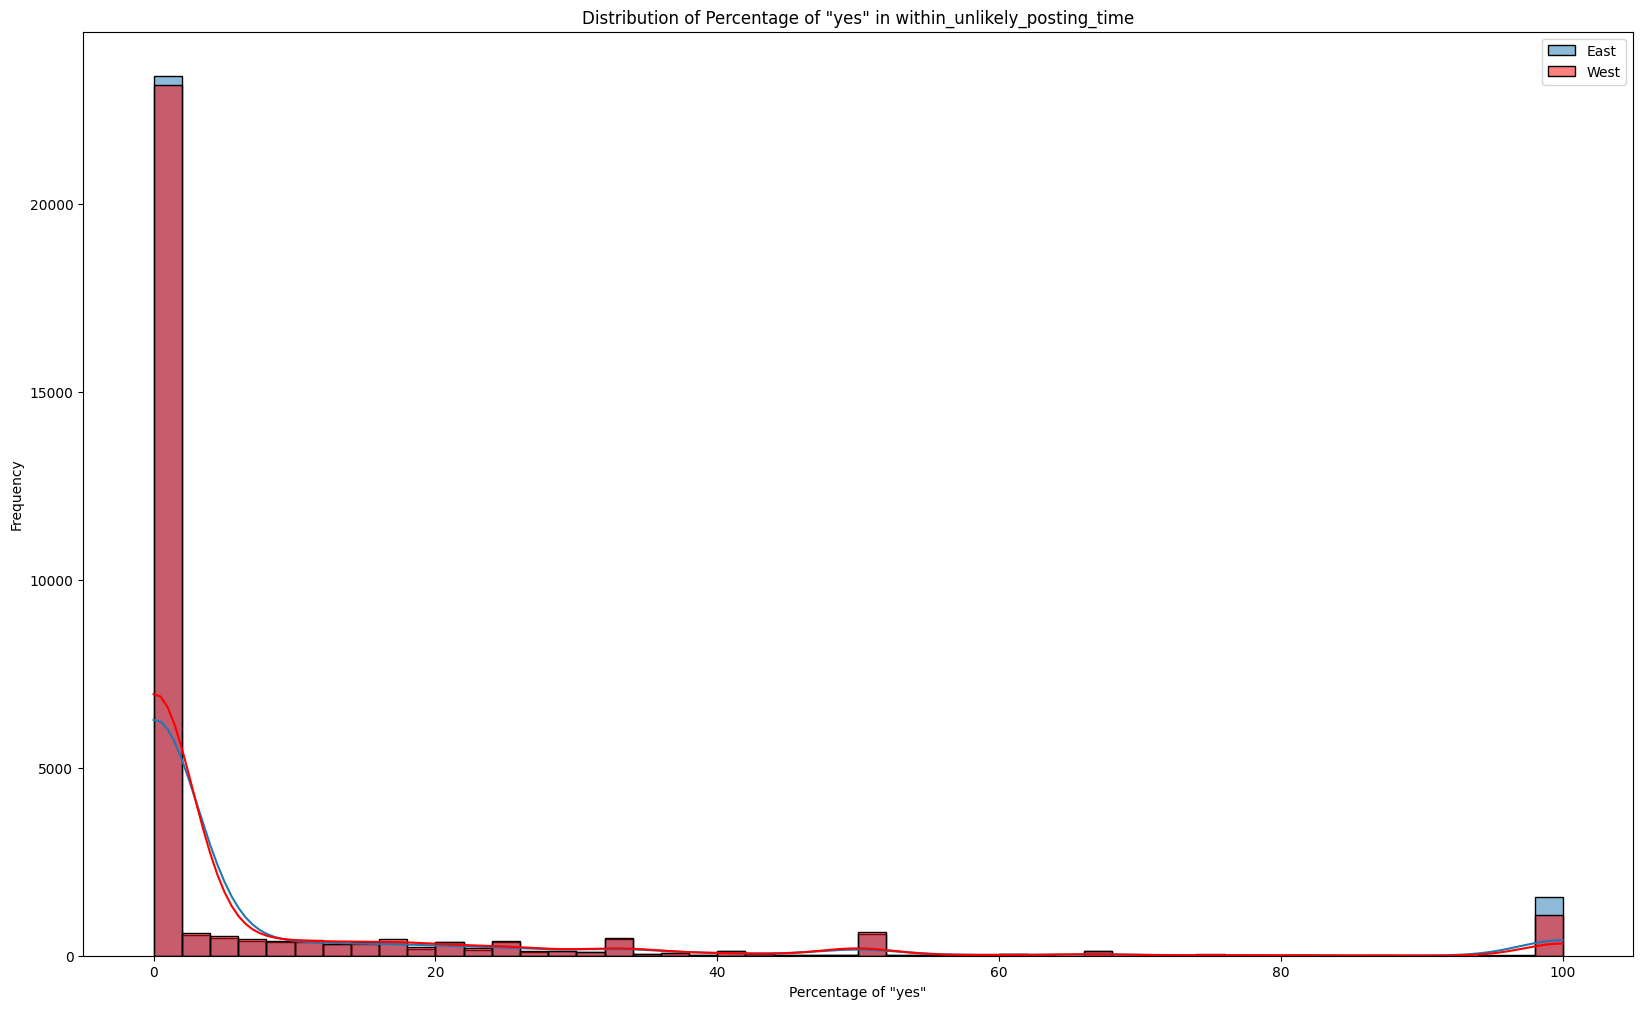

In [ ]:
plt.figure(figsize=(20, 12))

sns.histplot(percentage_yes['within_unlikely_posting_time_east'], kde=True, bins=50, label='East')
sns.histplot(percentage_yes['within_unlikely_posting_time_west'], kde=True, bins=50, label='West', color = 'red')

plt.xlabel('Percentage of "yes"')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of "yes" in within_unlikely_posting_time')
plt.legend()  # Show legend with labels
plt.show()

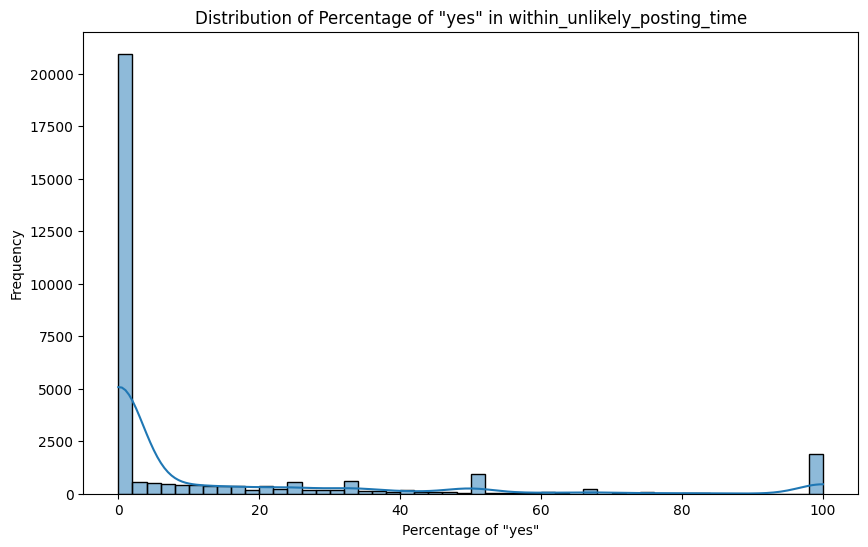

In [ ]:
# Plotting the distribution
plt.figure(figsize=(10,6))
sns.histplot(percentage_yes, kde=True, bins=50)
plt.xlabel('Percentage of "yes"')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of "yes" in within_unlikely_posting_time')
plt.show()

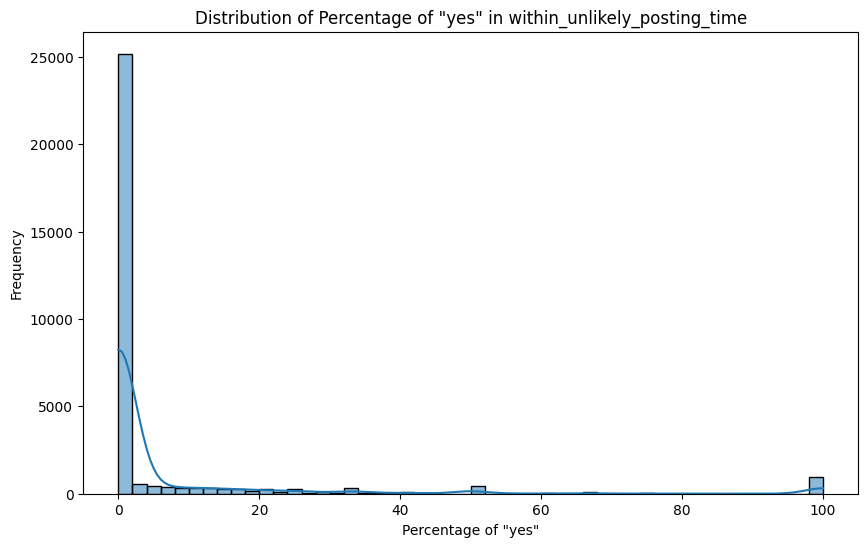

In [ ]:
'''DON'T RUN'''
### Below is the stats before enlarging the time interval to include West Coast time
# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(percentage_yes, kde=True, bins=50)
plt.xlabel('Percentage of "yes"')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage of "yes" in within_unlikely_posting_time')
plt.show()

# Deprecated Codes for Finding Climate-related Tweets

## Using Dictionary Method to find climate tweets in this 20% subgroup
- this result in 33012 climate-related tweets(using the broader set of keywords); and 11955 climate-related tweets(using the stricter set of keywords, which excludes three ambiguous words).
- This method is too strict and might cause the loss in useful data so we decided to abandon it.
- But I'll just leave it here just in case we need reference.(July 19th 2023)

In [ ]:
# Define the keywords queries
## keywords = ['climate change', '#climatechange', 'global warming', '#globalwarming']

keywords = ['global warming', 'climate change', 'agw' , 'climate' , 'climate realists', 'carbon dioxide', 'fossil fuel', 'carbon footprint', 'emissions',
            '#climatechange', '#climatechangeisreal', '#actonclimate', '#globalwarming', '#climatechangehoax', '#climatedeniers', '#climatechangeisfalse',
            '#globalwarminghoax', '#climatechangenotreal', 'climate hoax', ###end of previously used queries
            'climate emergency','#ClimateEmergency','#ClimateCrisis','climate crisis','#ClimateAction', 'climate action',
            '#renewables','renewables','green new deal', '#GreenNewDeal','energy',
            'hurricane','storm','Drought','Extreme Heat','Precipitation','Hurricane','Tornado','Wildfire','sea level','flood',
            'air quality']


In [ ]:
# Function to search for keywords in a given text and update the counts
def count_keywords(text):
    for keyword in keywords:
        if keyword.lower() in text.lower():
            keyword_counts[keyword] += 1

# Function to calculate the week start date for a given date
def get_week_start(date):
    return date - timedelta(days=date.weekday())

# Function to fix null bytes
def fix_nulls(s):
    for line in s:
        yield line.replace('\0', ' ')


In [ ]:
# A dictionary to store the frequencies for respective query keyword
keyword_counts = {keyword: 0 for keyword in keywords}

# Initialize a list to store weekly frequencies
weekly_counts = []


In [ ]:
'''
### find climate tweets in this subgroup
###
subgroup_climate_tweets = []
subgroup_climate_dates = []kew
total_tweets = 0

for file_name in tqdm(os.listdir(cwd), desc="Processing CSV files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join(cwd, file_name)
        with open(file_path, 'r', encoding='utf-8') as csv_file:
            csv_reader = csv.DictReader(fix_nulls(csv_file))

            # csv_reader = csv.reader((line.replace('\0','') for line in csv_file))
            for row in csv_reader:
              if row['author_id'] in top_20_ids_set:
                total_tweets += 1
                try:
                    tweet_time = row['created_at']
                    tweet_lang = row['lang']
                    # Check if the tweet has a datetime field; only those with one will be included
                    if tweet_time and any(keyword.lower() in str(row['text']).lower() for keyword in keywords):
                      count_keywords(str(row['text']))
                      subgroup_climate_tweets.append(str(row['text']))
                      subgroup_climate_dates.append(str(row['created_at']))
                except csv.Error as e:
                    print(f"Error occurred while processing {row}: {str(e)}")
                    continue
    else:
      print()
      print(f"skipping non-csv {file_name}")
      continue
'''

'\n### find climate tweets in this subgroup\n###\nsubgroup_climate_tweets = []\nsubgroup_climate_dates = []\ntotal_tweets = 0\n\nfor file_name in tqdm(os.listdir(cwd), desc="Processing CSV files"):\n    if file_name.endswith(\'.csv\'):\n        file_path = os.path.join(cwd, file_name)\n        with open(file_path, \'r\', encoding=\'utf-8\') as csv_file:\n            csv_reader = csv.DictReader(fix_nulls(csv_file))\n\n            # csv_reader = csv.reader((line.replace(\'\x00\',\'\') for line in csv_file))\n            for row in csv_reader:\n              if row[\'author_id\'] in top_20_ids_set:\n                total_tweets += 1\n                try:\n                    tweet_time = row[\'created_at\']\n                    tweet_lang = row[\'lang\']\n                    # Check if the tweet has a datetime field; only those with one will be included\n                    if tweet_time and any(keyword.lower() in str(row[\'text\']).lower() for keyword in keywords):\n                     

In [ ]:
'''Don't Run'''
# search result with the all the keywords
len(subgroup_climate_tweets)

NameError: ignored

In [ ]:
'''Don't Run'''
# excluding three frequently-used words - 'energy', 'storm', 'flood'
keywords2= ['global warming', 'climate change', 'agw' , 'climate' , 'climate realists', 'carbon dioxide', 'fossil fuel', 'carbon footprint', 'emissions',
            '#climatechange', '#climatechangeisreal', '#actonclimate', '#globalwarming', '#climatechangehoax', '#climatedeniers', '#climatechangeisfalse',
            '#globalwarminghoax', '#climatechangenotreal', 'climate hoax', ###end of previously used queries
            'climate emergency','#ClimateEmergency','#ClimateCrisis','climate crisis','#ClimateAction', 'climate action',
            '#renewables','renewables','green new deal', '#GreenNewDeal',
            'hurricane','Drought','Extreme Heat','Precipitation','Hurricane','Tornado','Wildfire','sea level',
            'air quality']

In [ ]:
'''Don't Run'''
# search result with stricter keywords
smaller_subgroup = [tweet for tweet in subgroup_climate_tweets if any(keyword.lower() in tweet.lower() for keyword in keywords2)]

In [ ]:
'''Don't Run'''
len(smaller_subgroup)

## Dictionary Methods From the Entire Data


In [ ]:
# initialize lists for storing tweets and dates
all_climate_tweets = []
all_climate_dates = []
for file_name in tqdm(os.listdir(cwd), desc="Processing CSV files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join(cwd, file_name)
        with open(file_path, 'r', encoding='utf-8') as csv_file:
            csv_reader = csv.DictReader(fix_nulls(csv_file))

            # csv_reader = csv.reader((line.replace('\0','') for line in csv_file))
            for row in csv_reader:
                try:
                    tweet_time = row['created_at']
                    tweet_lang = row['lang']
                    # Check if the tweet has a datetime field; only those with one will be included

                    if tweet_time and tweet_lang == 'en' and any(keyword.lower() in str(row['text']).lower() for keyword in keywords):
                        count_keywords(str(row['text']))
                        all_climate_tweets.append(str(row['text']))
                        all_climate_dates.append(str(row['created_at']))
                except csv.Error as e:
                    print(f"Error occurred while processing {row}: {str(e)}")
                    continue
    else:
      print()
      print(f"skipping non-csv {file_name}")
      continue


Processing CSV files:  88%|████████▊ | 43/49 [24:02<04:55, 49.19s/it]


skipping non-csv check_users.ipynb

skipping non-csv data_cps


Processing CSV files: 100%|██████████| 49/49 [25:55<00:00, 31.74s/it]


skipping non-csv extracted_user_ids(old)

skipping non-csv extracted_user_ids(byMay30)


In [ ]:
  len(all_climate_tweets)

108843

In [ ]:
all_climate_tweets[1:50]

['RT @TVMohandasPai: Japan issues missive to Andhra Pradesh over reworking of clean-energy PPAs: Report\n\n\u2066@ysjagan\u2069 has destroyed the trust o…',
 'United Nations Authority: Flood Rescue Operations In Kashmir (India) http://t.co/DKQgkJMiSl',
 'RT @PIB_India: Sh. Prakash Javadekar takes charge as  Minister of State(Independent Charge) for Environment, Forest &amp; Climate Change http:/…',
 '@narendramodi @PMOIndia Rename PowerNCoal Portfolio to #Energy Portfolio n club related ScienceNTechnology portfolio with it like #US #DoE',
 'RT @naralokesh: Both branches of Sonia, TRS &amp; YCP, trying to spread false news on NTR Trust. Where were you during Uttarakhand floods? Farm…',
 '@ncbn CBN instead of starting aatma gourava yatra form November 5th. This is the opportunity for you to come on field (visit flood areas)',
 '@ncbn sir you role in saving Uttarakhand flood victims was commendable we are hoping the same with recent #floods. Lost hope on #AP Govt.',
 "for next 24 hrs #ish

In [ ]:

# Create a dictionary with the data
data = {
    'tweet': all_climate_tweets,
    'date': all_climate_dates
}
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Add a new column 'year_month' by converting the 'date' column to year-month format
df['week'] = df['date'].dt.to_period('W')

df['month'] = df['date'].dt.to_period('M')
# Print the DataFrame
print(df)


                                                    tweet  \
0       Скачать Sky gamblers storm raiders for mac os ...   
1       Скачать Игра на компьютер naruto shippuden ult...   
2                                 https://t.co/Om4lj1agwM   
3       @news18dotcom @CNNnews18 This is the new trend...   
4       RT @TVMohandasPai: Japan issues missive to And...   
...                                                   ...   
125254  RT @tornadopayne: More ups/ downs ahead.  Slig...   
125255  #Repost @heartmyboyz with @repostapp.\n・・・\nHu...   
125256  RT @soccerdotcom: Another look at the newest T...   
125257  FELIZ CUMPLEAÑOS PARA MI &lt;3 http://t.co/agW...   
125258       y do people just wanna take ur Energy???????   

                            date                   week    month  
0      2014-03-28 12:47:46+00:00  2014-03-24/2014-03-30  2014-03  
1      2014-03-08 11:18:42+00:00  2014-03-03/2014-03-09  2014-03  
2      2019-10-14 17:56:02+00:00  2019-10-14/2019-10-20  2019-10  

<ipython-input-20-8be8b863aa1b>:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['date'].dt.to_period('W')
<ipython-input-20-8be8b863aa1b>:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')


In [ ]:
# Convert the 'week' column to datetime type
df['week'].dtype

period[W-SUN]

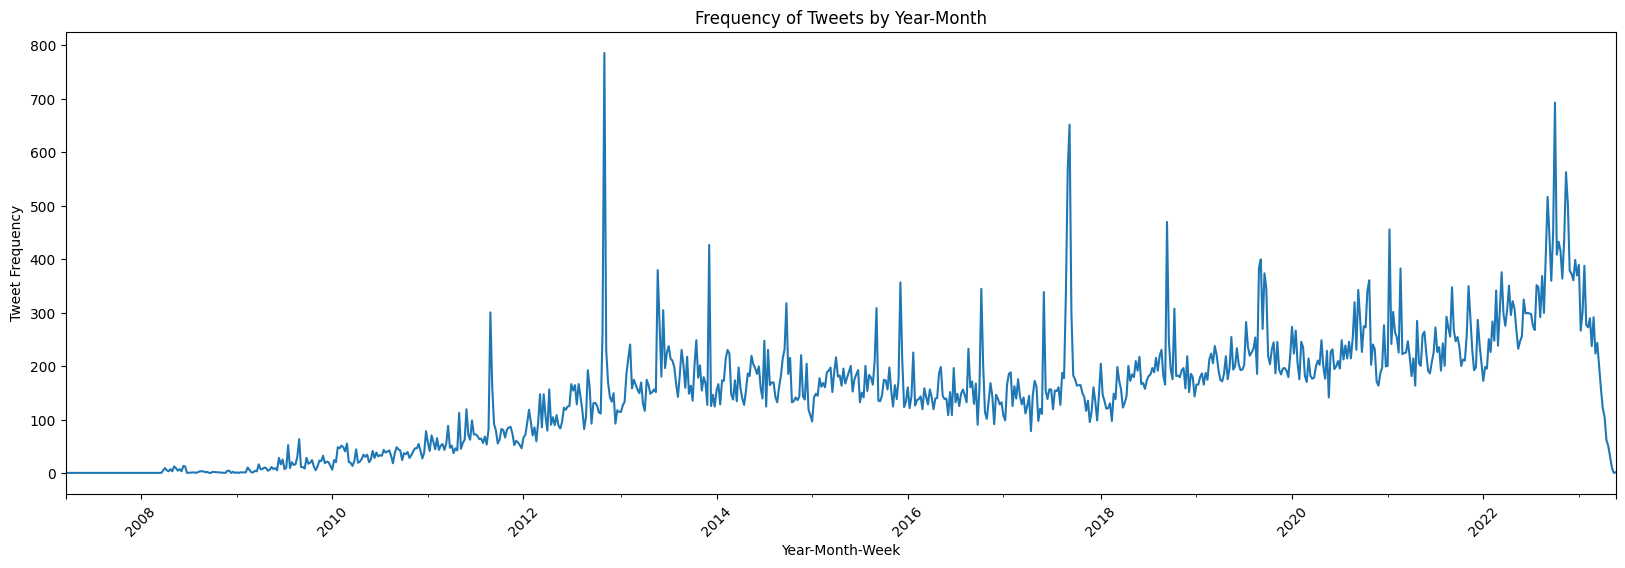

In [ ]:
# Group the DataFrame by week and count the number of tweets in each week
weekly_counts = df.groupby('week').size()

# Plot the time series of tweet frequencies
plt.figure(figsize=(20, 6))
weekly_counts.plot()
plt.xlabel('Year-Month-Week')
plt.ylabel('Tweet Frequency')
plt.title('Frequency of Tweets by Year-Month')

# Adjust the x-axis tick labels to include year, month, and week
plt.xticks(rotation=45)

plt.show()

In [ ]:
weekly_counts.sort_values(ascending = False).head(50)

week
2012-10-29/2012-11-04    786
2022-09-26/2022-10-02    693
2017-09-04/2017-09-10    652
2017-08-28/2017-09-03    569
2022-11-07/2022-11-13    563
2022-08-29/2022-09-04    517
2022-11-14/2022-11-20    503
2018-09-10/2018-09-16    470
2021-01-04/2021-01-10    456
2022-09-19/2022-09-25    450
2022-09-05/2022-09-11    443
2022-10-31/2022-11-06    436
2022-10-10/2022-10-16    433
2013-12-02/2013-12-08    427
2022-10-17/2022-10-23    416
2022-10-03/2022-10-09    409
2022-08-22/2022-08-28    407
2019-09-02/2019-09-08    400
2022-12-12/2022-12-18    399
2022-12-26/2023-01-01    390
2023-01-16/2023-01-22    388
2019-08-26/2019-09-01    384
2021-02-15/2021-02-21    383
2013-05-20/2013-05-26    380
2022-11-21/2022-11-27    379
2022-03-07/2022-03-13    376
2019-09-16/2019-09-22    374
2022-11-28/2022-12-04    373
2022-12-19/2022-12-25    370
2022-08-08/2022-08-14    369
2022-10-24/2022-10-30    364
2022-12-05/2022-12-11    361
2020-10-19/2020-10-25    361
2022-09-12/2022-09-18    360
2015-11-3

In [ ]:

# Print the frequency counts
for keyword, count in keyword_counts.items():
    print(f'{keyword}: {count}')


global warming: 1123
climate change: 5414
agw: 7600
climate: 16169
climate realists: 1
carbon dioxide: 191
fossil fuel: 1171
carbon footprint: 232
emissions: 1214
#climatechange: 1420
#climatechangeisreal: 48
#actonclimate: 221
#globalwarming: 183
#climatechangehoax: 2
#climatedeniers: 1
#climatechangeisfalse: 0
#globalwarminghoax: 0
#climatechangenotreal: 0
climate hoax: 16
climate emergency: 109
#ClimateEmergency: 122
#ClimateCrisis: 252
climate crisis: 572
#ClimateAction: 370
climate action: 358
#renewables: 60
renewables: 339
green new deal: 275
#GreenNewDeal: 95
energy: 39374
hurricane: 9851
storm: 34224
Drought: 1586
Extreme Heat: 135
Precipitation: 114
Hurricane: 9851
Tornado: 3744
Wildfire: 1400
sea level: 328
flood: 9212
air quality: 456


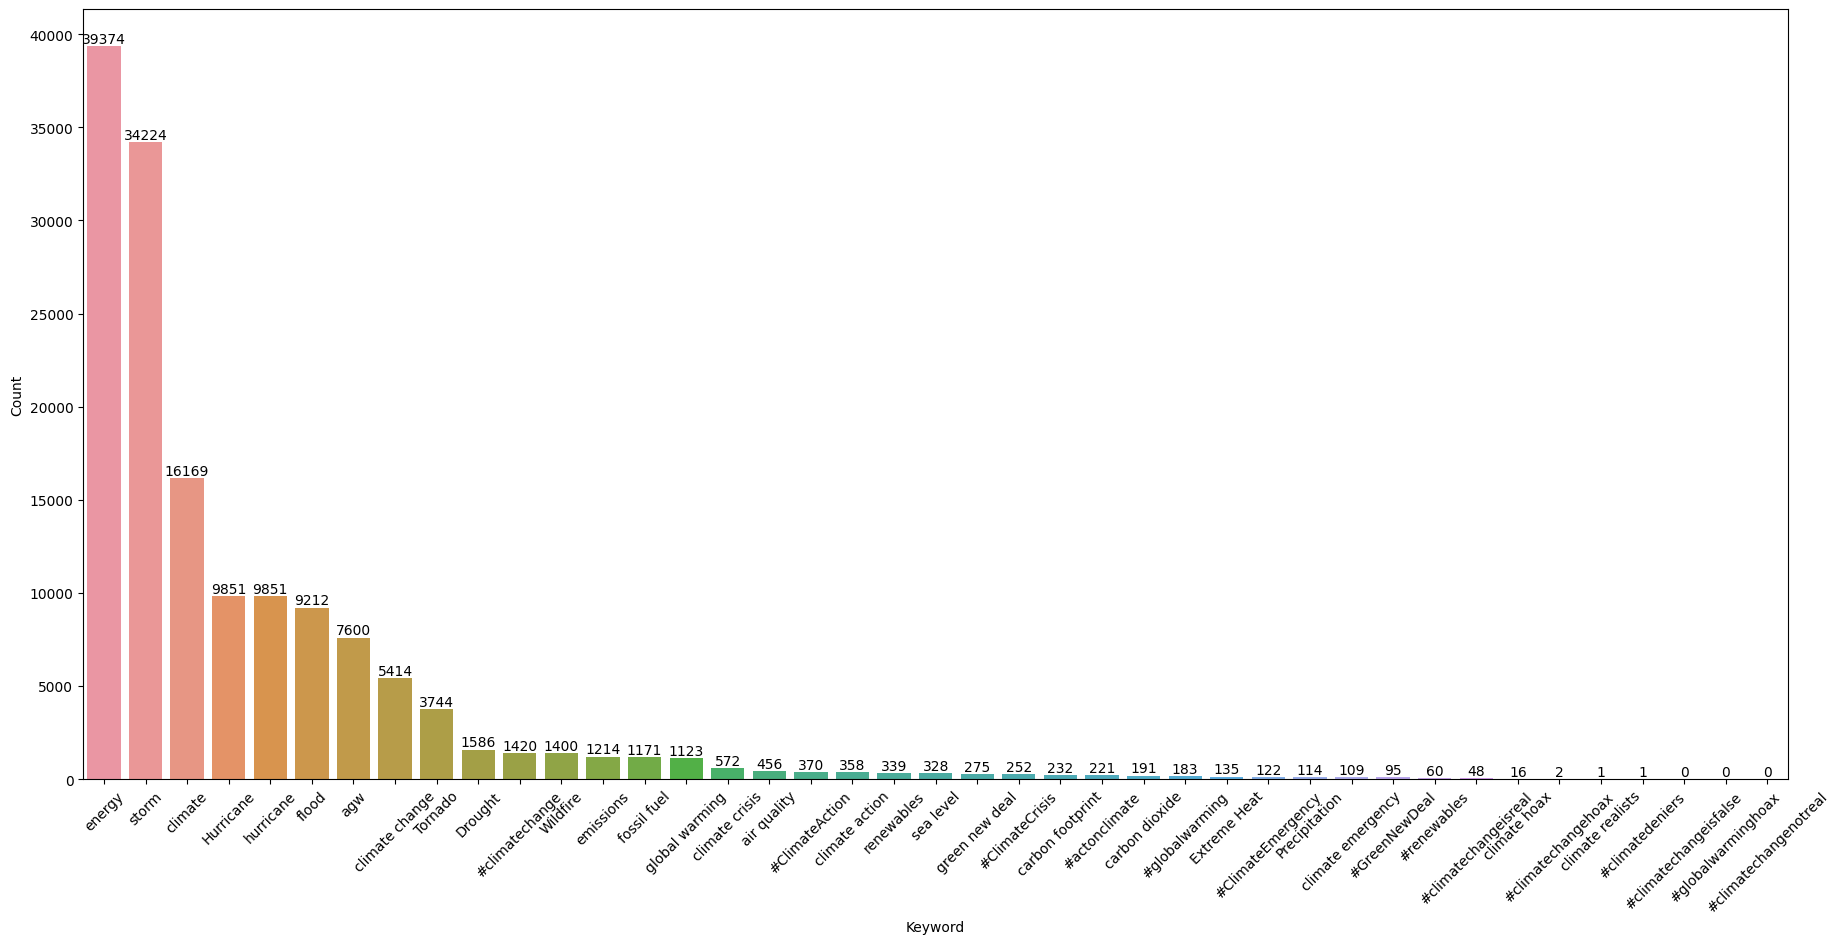

In [ ]:
# Convert the dictionary to a DataFrame
df_keyword_counts = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])
df_keyword_counts = df_keyword_counts.sort_values('Count', ascending=False)

# bar plot
plt.figure(figsize=(22, 10))
ax = sns.barplot(data=df_keyword_counts, x='Keyword', y='Count')
plt.xticks(rotation=45)
for i, row in enumerate(df_keyword_counts.itertuples(), start=0):
    ax.annotate(row.Count, xy=(i, row.Count), ha='center', va='bottom')
plt.show()

In [ ]:
## Testing NER using TweetNLP

In [ ]:
import tweetnlp
from collections import defaultdict #initialize a origianl dict with lists instead of an empty dict

In [ ]:
# model
model = tweetnlp.load_model('ner')

In [ ]:

# Dictionary to store NER results
ner_results = defaultdict(list)

# Perform NER prediction for each tweet

for file_name in tqdm(os.listdir(cwd), desc="Processing CSV files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join(cwd, file_name)
        with open(file_path, 'r', encoding='utf-8') as csv_file:
            csv_reader = csv.DictReader(fix_nulls(csv_file))

            # csv_reader = csv.reader((line.replace('\0','') for line in csv_file))
            for row in csv_reader:
                try:
                    tweet_text= row['text']
                    tweet_auth = row['author_id']
                    # Check if the tweet has a datetime field; only those with one will be included
                    ner_result = model.ner(tweet_text)
                    # Store the NER results in the corresponding author_id list
                    ner_results[tweet_auth].append(ner_result)
                except csv.Error as e:
                    print(f"Error occurred while processing {row}: {str(e)}")
                    continue
        break



Processing CSV files:   0%|          | 0/49 [2:03:54<?, ?it/s]


TypeError: ignored

In [ ]:
ner_results

defaultdict(list,
            {'105005791': [[{'type': 'product', 'entity': 'Случайная'},
               {'type': 'product', 'entity': '�стреч'}],
              [{'type': 'product', 'entity': '�ынужден'},
               {'type': 'product', 'entity': '�ережить'}],
              [{'type': 'product', 'entity': 'Фронтмен группы Ленинград Шнур'},
               {'type': 'product', 'entity': '�девается'},
               {'type': 'product', 'entity': '�ак Виктория Бэкхем.'},
               {'type': 'product', 'entity': 'сказать'},
               {'type': 'product', 'entity': 'утонченный вкус'}],
              [{'type': 'product', 'entity': 'распрекрас'}],
              [{'type': 'product', 'entity': 'Поскоре'},
               {'type': 'product', 'entity': '�тмосфер'}],
              [{'type': 'product', 'entity': 'сожалению'},
               {'type': 'product', 'entity': ' Александр Д�'}],
              [{'type': 'product', 'entity': 'Человека'},
               {'type': 'product', 'entity': '

In [ ]:
# Initialize dictionary to store location columns for each user
user_locations = {}

# Iterate over NER results and extract location information
for i, ner_result in enumerate(ner_results, 1):
    locations = [entity['entity'] for entity in ner_result if entity['type'] == 'location']
    user_locations[i] = locations

# Create DataFrame from the dictionary
df = pd.DataFrame.from_dict(user_locations, orient='index')

# Set column names as locations
df.columns = df.columns.map(str.strip)

print(df)

NameError: ignored

## Using Climate Detection Model to locate Climate tweets
https://huggingface.co/climatebert/distilroberta-base-climate-detector
- plan:
    - start with grabbing all tweets from the top20% users.
      - run model and see how much is left
        - compare the number to our stricter subgroup and looser subgroup and see.

    - test whether it can distinguish nuances of "storm, energy, etc"(run it in the subgroup???" but if step 1 is significantly better(leave us with more tweets, this step could go obsolete.

    - maybe later we should also try this with the entire user population???and compare it with the keyword search result again.

In [ ]:
pip install transformers

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from transformers.pipelines.pt_utils import KeyDataset
import datasets
from tqdm.auto import tqdm

In [ ]:
#Load dataset
dataset_name = "climatebert/climate_detection"
model_name = "climatebert/distilroberta-base-climate-detector"

# If you want to use your own data, simply load them as 🤗 Datasets dataset, see https://huggingface.co/docs/datasets/loading
dataset = datasets.load_dataset(dataset_name, split="test")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1300 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/climatebert___parquet/climatebert--climate_detection-eefa7af3c8031d26/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


### gather all the tweets from the top20% users

In [ ]:
## increase csv cize limit to circumvent error
csv.field_size_limit(100000000)
csv.field_size_limit()

100000000

In [ ]:
'''
final_file_path = 'all_tweets_from_top20_users.csv'
with open(final_file_path, mode = 'w')as file:
  file.write('author_id,time,lang,text\n')  # write header

  for file_name in tqdm(os.listdir(cwd), desc="Processing CSV files"):
      if file_name.endswith('.csv'):
          file_path = os.path.join(cwd, file_name)
          with open(file_path, 'r', encoding='utf-8') as csv_file:
              csv_reader = csv.DictReader(fix_nulls(csv_file))

              for row in csv_reader:
                try:
                  row_list = list(row.values())
                  if row_list[1] in top_20_ids_set:
                    tweet_author = row_list[1]
                    tweet_time = row_list[2]
                    tweet_lang = row_list[7]
                    tweet_text = row_list[8].replace('\n','')
                    new_row = f"{tweet_author},{tweet_time},{tweet_lang},{tweet_text}]\n"
                    file.write(new_row)
                except Exception as e:
                    print(f"Error occurred while processing {row}: {str(e)}")
                    continue
      else:
        print()
        print(f"skipping non-csv {file_name}")
        continue

'''

Processing CSV files:  78%|███████▊  | 43/55 [09:45<03:45, 18.75s/it]


skipping non-csv check_users.ipynb

skipping non-csv data_cps


Processing CSV files:  85%|████████▌ | 47/55 [10:30<01:48, 13.51s/it]


skipping non-csv extracted_user_ids(old)

skipping non-csv extracted_user_ids(byMay30)

skipping non-csv USERS_METADATA

skipping non-csv eng_users.pkl

skipping non-csv all_users.pkl

skipping non-csv top_20_Eng_ids.txt

skipping non-csv all_tweets_from_top20_users.txt


Processing CSV files: 100%|██████████| 55/55 [10:49<00:00, 11.82s/it]


In [ ]:
final_file_path = 'all_tweets_from_top20_users.csv'
with open(final_file_path, mode = 'r')as file:
  all_tweets_top20 = file.readlines()

In [ ]:
len(all_tweets_top20)

3294241

In [ ]:
all_tweets_top20_cleaned = sorted(list(set(all_tweets_top20)))

In [ ]:
top_20_tweets = [tweet.strip(']\n') for tweet in all_tweets_top20_cleaned]

In [ ]:
'''Don't run'''
### format top 20% tweets into a list of dictionaries
processed_data = []

for row in tqdm(top_20_tweets):
    row_values = row.split(',')

    if len(row_values) >= 4:
        ID = row_values[0]
        timestamp = row_values[1]
        language = row_values[2]
        text = ','.join(row_values[3:])

        record = {
            "ID": ID,
            "timestamp": timestamp,
            "language": language,
            "text": text
        }

        processed_data.append(record)
### save to file
with open("processed_top20_tweets.json", "w") as json_file:
      json.dump(processed_data, json_file)